# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
import math
def nCr(n,r):
    f = math.factorial
    return f(n) // f(r) // f(n-r)

In [2]:
d = 3  
n = 4
sparsity = nCr(n+d, d)

x_max = 1#10 #this number excluded
x_min = -1#-10
x_step = 0.01#0.1
a_max = 10 #this number excluded
a_min = -10
a_step = 0.1

n_jobs = 11


data_size = 10000 #for loading lambda models

#specify interpretation net structure
optimizer = 'adam'
dropout = 0
epochs = 100
batch_size = 128
interpretation_network_layers = [2048]

random_evaluation_dataset_size = 500

#lambda net specifications for loading (need to be set according to lambda net training to load correct weights)
epochs_lambda = 200
batch_lambda = 64
lambda_network_layers = [5*sparsity]
optimizer_lambda = '_' + 'SGD'


lambda_dataset_size = 1000

#set if multi_epoch_analysis should be performed
multi_epoch_analysis = True
each_epochs_save_lambda = 20 #None if no checkpointing (otherwise set according to lambda-net training)
epoch_start = 0 #use to skip first epochs in multi_epoch_analysis

#set if samples analysis should be performed
samples_list = None#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 

evaluate_with_real_function = False
consider_labels_training = False

same_training_all_lambda_nets = False

fixed_seed_lambda_training = False
fixed_initialization_lambda_training = True
number_different_lambda_trainings = 50

inet_holdout_seed_evaluation = True
seed_in_inet_training = True


In [3]:
##############DO NOT CHANGE###################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n] 

RANDOM_SEED = 42

epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else None

advanced_metric_dataset_size = 10#200

use_gpu = False
if use_gpu:
    gpu_numbers = '0'
else:
    gpu_numbers = ''

if fixed_seed_lambda_training:
    seed_shuffle_string = '_' + str(number_different_lambda_trainings) + '-FixedSeed'
else:
    seed_shuffle_string = '_NoFixedSeed'
    
if fixed_initialization_lambda_training:
    seed_shuffle_string += '_' + str(number_different_lambda_trainings) + '-FixedEvaluation'
else:
    seed_shuffle_string += '_NoFixedEvaluation'

if same_training_all_lambda_nets:
    training_string = '_same'
else:
    training_string = '_diverse'

layers_str = ''.join([str(neurons) + '-' for neurons in lambda_network_layers])

structure = '_' + layers_str + str(epochs_lambda) + 'e' + str(batch_lambda) + 'b' + optimizer_lambda
filename = seed_shuffle_string + '_' + str(RANDOM_SEED) + structure

interpretation_network_string = 'drop' + str(dropout) + 'e' + str(epochs) + 'b' + str(batch_size) + '_' + str(interpretation_network_layers)



## Imports

In [4]:
import ttg
from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 

import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers
import shutil

import logging
logging.getLogger('tensorflow').disabled = True

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image
from sklearn.preprocessing import Normalizer

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

import tensorflow as tf
import random 
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

try:
    # Create target Directory
    os.mkdir('./data/plotting/' + interpretation_network_string + filename + '/')
    os.mkdir('./data/results/' + interpretation_network_string + filename + '/')
except FileExistsError:
    pass

import warnings
warnings.filterwarnings('ignore')

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

In [6]:
#Utility Functions

ALPHABET = \
  "0123456789abcdefghijklmnopqrstuvwxyz"

def encode (n):
    try:
        return ALPHABET [n]
    except IndexError:
        raise Exception ("cannot encode: %s" % n)
        
def dec_to_base (dec = 0, base = 16):
    if dec < base:
        return encode (dec)
    else:
        return dec_to_base (dec // base, base) + encode (dec % base)

def return_float_tensor_representation(some_representation, dtype=tf.float32):
    if tf.is_tensor(some_representation):
        some_representation = tf.dtypes.cast(some_representation, dtype) 
    else:
        some_representation = tf.convert_to_tensor(some_representation)
        some_representation = tf.dtypes.cast(some_representation, dtype) 
        
    if not tf.is_tensor(some_representation):
        raise SystemExit('Given variable is no instance of ' + str(dtype) + ':' + str(some_representation))
     
    return some_representation


def return_numpy_representation(some_representation):
    if isinstance(some_representation, pd.DataFrame):
        some_representation = some_representation.values
        
    if isinstance(some_representation, list):
        some_representation = np.array(some_representation)
    
    if not isinstance(some_representation, np.ndarray):
        raise SystemExit('Given variable is no instance of ' + str(np.ndarray) + ':' + str(some_representation))
    
    return some_representation

def mergeDict(dict1, dict2):
    #Merge dictionaries and keep values of common keys in list
    newDict = {**dict1, **dict2}
    for key, value in newDict.items():
        if key in dict1 and key in dict2:
            if isinstance(dict1[key], list) and isinstance(value, list):
                newDict[key] = dict1[key]
                newDict[key].extend(value)
            elif isinstance(dict1[key], list) and not isinstance(value, list):
                newDict[key] = dict1[key]
                newDict[key].extend([value])
            elif not isinstance(dict1[key], list) and isinstance(value, list):
                newDict[key] = [dict1[key]]
                newDict[key].extend(value)
            else:
                newDict[key] = [dict1[key], value]
    return newDict

def return_callbacks_from_string(callback_string_list):
    callbacks = [] if len(callback_string_list) > 0 else None
    #if 'plot_losses_callback' in callback_string_list:
        #callbacks.append(PlotLossesCallback())
    if 'reduce_lr_loss' in callback_string_list:
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=epochs/10, verbose=0, min_delta=0, mode='min') #epsilon
        callbacks.append(reduce_lr_loss)
    if 'early_stopping' in callback_string_list:
        earlyStopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0, verbose=0, mode='min')
        callbacks.append(earlyStopping)
        
    #if not multi_epoch_analysis and samples_list == None: 
        #callbacks.append(TQDMNotebookCallback())
        
    return callbacks

def arreq_in_list(myarr, list_arrays):
    return next((True for elem in list_arrays if np.array_equal(elem, myarr)), False)

def generate_random_x_values(size, x_max, x_min, x_step, numnber_of_variables):
    x_values_list = []
    
    for j in range(size):
        values = np.round(np.array(random_product(np.arange(x_min, x_max, x_step), repeat=numnber_of_variables)), int(-np.log10(x_step)))
        while arreq_in_list(values, x_values_list):
                values = np.round(np.array(random_product(np.arange(x_min, x_max, x_step), repeat=numnber_of_variables)), int(-np.log10(x_step)))         
        x_values_list.append(values)
    
    return np.array(x_values_list)


### Generate List of Monomial Identifiers

In [7]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)



List length: 256
Number of monomials in a polynomial with 4 variables and degree 3: 35
Sparsity: 35
['0000', '0001', '0002', '0003', '0010', '0011', '0012', '0013', '0020', '0021', '0022', '0023', '0030', '0031', '0032', '0033', '0100', '0101', '0102', '0103', '0110', '0111', '0112', '0113', '0120', '0121', '0122', '0123', '0130', '0131', '0132', '0133', '0200', '0201', '0202', '0203', '0210', '0211', '0212', '0213', '0220', '0221', '0222', '0223', '0230', '0231', '0232', '0233', '0300', '0301', '0302', '0303', '0310', '0311', '0312', '0313', '0320', '0321', '0322', '0323', '0330', '0331', '0332', '0333', '1000', '1001', '1002', '1003', '1010', '1011', '1012', '1013', '1020', '1021', '1022', '1023', '1030', '1031', '1032', '1033', '1100', '1101', '1102', '1103', '1110', '1111', '1112', '1113', '1120', '1121', '1122', '1123', '1130', '1131', '1132', '1133', '1200', '1201', '1202', '1203', '1210', '1211', '1212', '1213', '1220', '1221', '1222', '1223', '1230', '1231', '1232', '1233', '1


List length: 35
Number of monomials in a polynomial with 4 variables and degree 3: 35
Sparsity: 35
['0000', '0001', '0002', '0003', '0010', '0011', '0012', '0020', '0021', '0030', '0100', '0101', '0102', '0110', '0111', '0120', '0200', '0201', '0210', '0300', '1000', '1001', '1002', '1010', '1011', '1020', '1100', '1101', '1110', '1200', '2000', '2001', '2010', '2100', '3000']


## Loss/Error functions

In [8]:
#Manual TF Loss function for comparison with lambda-net prediction based (predictions made in loss function)


def mean_absolute_error_tf_fv_lambda_extended_wrapper(evaluation_dataset, list_of_monomial_identifiers, base_model):
    
    evaluation_dataset = return_float_tensor_representation(evaluation_dataset)
    list_of_monomial_identifiers = return_float_tensor_representation(list_of_monomial_identifiers)    
    
    model_lambda_placeholder = keras.models.clone_model(base_model)  
    
    weights_structure = base_model.get_weights()
    dims = [np_arrays.shape for np_arrays in weights_structure]
    
    def mean_absolute_error_tf_fv_lambda_extended(polynomial_true_with_lambda_fv, polynomial_pred):

        if seed_in_inet_training:
            network_parameters = polynomial_true_with_lambda_fv[:,sparsity+1:]
            polynomial_true = polynomial_true_with_lambda_fv[:,1:sparsity+1]
        else:
            network_parameters = polynomial_true_with_lambda_fv[:,sparsity:]
            polynomial_true = polynomial_true_with_lambda_fv[:,:sparsity]

        network_parameters = return_float_tensor_representation(network_parameters)
        polynomial_true = return_float_tensor_representation(polynomial_true)
        polynomial_pred = return_float_tensor_representation(polynomial_pred)
        
        assert(polynomial_true.shape[1] == sparsity)
        assert(polynomial_pred.shape[1] == sparsity)    
        
        return tf.math.reduce_mean(tf.map_fn(calculate_mae_fv_lambda_wrapper(evaluation_dataset, list_of_monomial_identifiers, dims, model_lambda_placeholder), (polynomial_pred, network_parameters), fn_output_signature=tf.float32))
    return mean_absolute_error_tf_fv_lambda_extended

def calculate_mae_fv_lambda_wrapper(evaluation_dataset, list_of_monomial_identifiers, dims, model_lambda_placeholder):

    def calculate_mae_fv_lambda(input_list):

        #single polynomials
        #polynomial_true = input_list[0]
        polynomial_pred = input_list[0]
        network_parameters = input_list[1]
        
        polynomial_pred_fv_list = tf.vectorized_map(calculate_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_pred), (evaluation_dataset))

        #CALCULATE LAMBDA FV HERE FOR EVALUATION DATASET
        # build models
        start = 0
        layers = []
        for i in range(len(dims)//2):
            
            # set weights of layer
            index = i*2
            size = np.product(dims[index])
            weights_tf_true = tf.reshape(network_parameters[start:start+size], dims[index])
            model_lambda_placeholder.layers[i].weights[0].assign(weights_tf_true)
            start += size
            
            # set biases of layer
            index += 1
            size = np.product(dims[index])
            biases_tf_true = tf.reshape(network_parameters[start:start+size], dims[index])
            model_lambda_placeholder.layers[i].weights[1].assign(biases_tf_true)
            start += size

        
        lambda_fv = tf.keras.backend.flatten(model_lambda_placeholder(evaluation_dataset))
        
        return tf.math.reduce_mean(tf.vectorized_map(calculate_mae_single_input, (lambda_fv, polynomial_pred_fv_list)))
    
    return calculate_mae_fv_lambda

def calculate_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_pred):


    def calculate_fv_from_data(evaluation_entry):


        value_without_coefficient = tf.vectorized_map(calculate_value_without_coefficient_wrapper(evaluation_entry), (list_of_monomial_identifiers))
        polynomial_pred_value_per_term = tf.vectorized_map(lambda x: x[0]*x[1], (value_without_coefficient, polynomial_pred))
        
        polynomial_pred_fv = tf.reduce_sum(polynomial_pred_value_per_term)     
        
        return polynomial_pred_fv
    return calculate_fv_from_data


#calculate intermediate term (without coefficient multiplication)
def calculate_value_without_coefficient_wrapper(evaluation_entry):
    def calculate_value_without_coefficient(coefficient_multiplier_term):      
   
        return tf.math.reduce_prod(tf.vectorized_map(lambda x: x[0]**x[1], (evaluation_entry, coefficient_multiplier_term)))
    return calculate_value_without_coefficient

#calculate MAE at the end ---> general:REPLACE FUNCTION WITH LOSS CALL OR LAMBDA
def calculate_mae_single_input(input_list):
    true_fv = input_list[0]
    pred_fv = input_list[1]

    return tf.math.abs(tf.math.subtract(true_fv, pred_fv))


def mean_absolute_error_extended(polynomial_true_with_lambda_fv, polynomial_pred): 
    if seed_in_inet_training:
        polynomial_true = polynomial_true_with_lambda_fv[:,1:sparsity+1]
    else:
        polynomial_true = polynomial_true_with_lambda_fv[:,:sparsity]    
    
    assert(polynomial_true.shape[1] == sparsity)
    assert(polynomial_pred.shape[1] == sparsity)
    
    return tf.keras.losses.MAE(polynomial_true, polynomial_pred)


In [9]:
#Manual TF Loss function for comparison with pre-saved lambda-net predictions (based on global eval set)

#extended means that the lambda-net predictions are appended to y_true 
#in order to get them into the loss function without loosing the allocation

def calculate_mae_single_input_preds_appended(input_list):
    true_fv = input_list[0]
    pred_fv = input_list[1]

    return tf.math.abs(tf.math.subtract(true_fv, pred_fv))


def calculate_mae_fv_lambda_preds_appended(input_list):
    
    polynomial_true = input_list[0]
    polynomial_pred = input_list[1]
    lambda_fv = input_list[2]

    global lambda_train_input_train_split 
    lambda_input = lambda_train_input_train_split[0] #[0] correct here?
    
    for index, lambda_input_entry in enumerate(lambda_input):
        value_without_coefficient = np.array([reduce(lambda x, y: x*y, [lambda_input_value**int(coefficient_multiplier) for coefficient_multiplier, lambda_input_value in zip(coefficient_multiplier_term, lambda_input_entry)]) for coefficient_multiplier_term in list_of_monomial_identifiers], dtype='float32')

        polynomial_pred_value_per_term = tf.vectorized_map(lambda x: x[0]*x[1], (value_without_coefficient, polynomial_pred))
        polynomial_pred_fv = tf.reduce_sum(polynomial_pred_value_per_term)

        if index == 0:
            polynomial_pred_fv_list = tf.convert_to_tensor([polynomial_pred_fv])
        else:
            polynomial_pred_fv_list = tf.concat([polynomial_pred_fv_list, tf.convert_to_tensor([polynomial_pred_fv])], 0)

    return tf.math.reduce_mean(tf.vectorized_map(calculate_mae_single_input_preds_appended, (lambda_fv, polynomial_pred_fv_list)))
  
    
def mean_absolute_error_tf_fv_lambda_preds_appended(polynomial_true_with_lambda_fv, polynomial_pred):

    if seed_in_inet_training:
        lambda_fv = polynomial_true_with_lambda_fv[:,sparsity+1:]
        polynomial_true = polynomial_true_with_lambda_fv[:,1:sparsity+1]
    else:
        lambda_fv = polynomial_true_with_lambda_fv[:,sparsity:]
        polynomial_true = polynomial_true_with_lambda_fv[:,:sparsity]

    assert(polynomial_true.shape[1] == sparsity)
    assert(polynomial_pred.shape[1] == sparsity)  
    
    return tf.math.reduce_mean(tf.vectorized_map(calculate_mae_fv_lambda_preds_appended, (polynomial_true, polynomial_pred, lambda_fv)))



In [10]:
#Basic Keras/TF Loss functions
def root_mean_squared_error(y_true, y_pred):   
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
        
    y_true =  return_float_tensor_representation(y_true)
    y_pred =  return_float_tensor_representation(y_pred)           
            
    return tf.math.sqrt(K.mean(K.square(y_pred - y_true))) 

def accuracy_multilabel(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    y_true =  return_float_tensor_representation(y_true)
    y_pred =  return_float_tensor_representation(y_pred) 
            
    n_digits = int(-np.log10(a_step))      
    y_true = tf.math.round(y_true * 10**n_digits) / (10**n_digits) 
    y_pred = tf.math.round(y_pred * 10**n_digits) / (10**n_digits) 
        
    return K.mean(tf.dtypes.cast(tf.dtypes.cast(tf.reduce_all(K.equal(y_true, y_pred), axis=1), tf.int32), tf.float32))#tf.reduce_all(K.equal(K.equal(y_true, y_pred), True), axis=1)#K.all(K.equal(y_true, y_pred)) #K.equal(y_true, y_pred)                        

def accuracy_single(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    y_true =  return_float_tensor_representation(y_true)
    y_pred =  return_float_tensor_representation(y_pred) 
            
    n_digits = int(-np.log10(a_step))
        
    y_true = tf.math.round(y_true * 10**n_digits) / (10**n_digits) 
    y_pred = tf.math.round(y_pred * 10**n_digits) / (10**n_digits) 
        
    return K.mean(tf.dtypes.cast(tf.dtypes.cast(K.equal(y_true, y_pred), tf.int32), tf.float32))#tf.reduce_all(K.equal(K.equal(y_true, y_pred), True), axis=1)#K.all(K.equal(y_true, y_pred)) #K.equal(y_true, y_pred)                        

def mean_absolute_percentage_error_keras(y_true, y_pred, epsilon=10e-3): 
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    y_true =  return_float_tensor_representation(y_true)
    y_pred =  return_float_tensor_representation(y_pred)        
    epsilon = return_float_tensor_representation(epsilon)
        
    return tf.reduce_mean(tf.abs(tf.divide(tf.subtract(y_pred, y_true),(y_true + epsilon))))

def huber_loss_delta_set(y_true, y_pred):
    return keras.losses.huber_loss(y_true, y_pred, delta=0.3)

In [11]:
#Manual calculations for comparison of polynomials based on function values (no TF!)

def calcualate_function_value(coefficient_list, lambda_input_entry):
    
    global list_of_monomial_identifiers
    
    result = 0   
        
    for coefficient_value, coefficient_multipliers in zip(coefficient_list, list_of_monomial_identifiers):
        value_without_coefficient = [lambda_input_value**int(coefficient_multiplier) for coefficient_multiplier, lambda_input_value in zip(coefficient_multipliers, lambda_input_entry)]

        result += coefficient_value * reduce(lambda x, y: x*y, value_without_coefficient)

    return result

def calculate_function_values_from_polynomial(polynomial, lambda_input_data):
    assert(len(polynomial) == sparsity)
    
    polynomial = return_numpy_representation(polynomial)
    
    function_value_list = []
        
    for lambda_input_entry in lambda_input_data:
        function_value = calcualate_function_value(polynomial, lambda_input_entry)
        function_value_list.append(function_value)

    return np.array(function_value_list)


def parallel_fv_calculation_from_polynomial(polynomial_list, lambda_input_list):
    parallel = Parallel(n_jobs=10, verbose=0, backend='threading')
    polynomial_true_fv = parallel(delayed(calculate_function_values_from_polynomial)(polynomial, lambda_inputs) for polynomial, lambda_inputs in zip(polynomial_list, lambda_input_list))  
    del parallel   
    

    return np.array(polynomial_true_fv)



In [12]:
#Standard Metrics (no TF!)

def mean_absolute_error_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)      
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.mean(np.abs(true_values-pred_values)))
    
    return np.mean(np.array(result_list))  

def root_mean_squared_error_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)         
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.sqrt(np.mean((true_values-pred_values)**2)))
    
    return np.mean(np.array(result_list)) 

def mean_absolute_percentage_error_function_values(y_true, y_pred, epsilon=10e-3):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred) 
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.mean(np.abs(((true_values-pred_values)/(true_values+epsilon)))))

    return np.mean(np.array(result_list))

def r2_score_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(r2_score(true_values, pred_values))
    
    return np.mean(np.array(result_list))

def relative_absolute_average_error_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    result_list = []
    
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.sum(np.abs(true_values-pred_values))/(true_values.shape[0]*np.std(true_values)))
    
    return np.mean(np.array(result_list))

def relative_maximum_average_error_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.max(true_values-pred_values)/np.std(true_values))
    
    return np.mean(np.array(result_list))

def mean_area_between_two_curves_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
      
    assert(number_of_variables==1)
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(area_between_two_curves(true_values, pred_values))
 
    return np.mean(np.array(result_list))

def mean_dtw_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)

    result_list_single = []
    result_list_array = []
    
    for true_values, pred_values in zip(y_true, y_pred):
        result_single_value, result_single_array = dtw(true_values, pred_values)
        result_list_single.append(result_single_value)
        result_list_array.append(result_single_array)
    
    return np.mean(np.array(result_list_single)), np.mean(np.array(result_list_array), axis=1)

def mean_frechet_dist_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(frechet_dist(true_values, pred_values))
    
    return np.mean(np.array(result_list))


In [13]:
def evaluate_interpretation_net(y_data_real, 
                                y_data_pred, 
                                polynomial_true_fv, 
                                polynomial_pred_inet_fv):
    
    
    assert(y_data_real.shape[1] == sparsity)
    assert(y_data_pred.shape[1] == sparsity)
    
    mae_coeff = np.round(mean_absolute_error(y_data_real, y_data_pred), 4)
    rmse_coeff = np.round(root_mean_squared_error(y_data_real, y_data_pred), 4)
    mape_coeff = np.round(mean_absolute_percentage_error_keras(y_data_real, y_data_pred), 4)
    accuracy_coeff = np.round(accuracy_single(y_data_real, y_data_pred), 4)
    accuracy_multi_coeff = np.round(accuracy_multilabel(y_data_real, y_data_pred), 4)

    
    mae_fv = np.round(mean_absolute_error_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    rmse_fv = np.round(root_mean_squared_error_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    mape_fv = np.round(mean_absolute_percentage_error_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    r2_fv = np.round(r2_score_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    raae_fv = np.round(relative_absolute_average_error_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    rmae_fv = np.round(relative_maximum_average_error_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4) 

    std_fv = np.std(polynomial_pred_inet_fv)
    mean_fv = np.mean(polynomial_pred_inet_fv)

    return {
             'MAE': mae_coeff,
             'RMSE': rmse_coeff, 
             'MAPE': mape_coeff,
             'Accuracy': accuracy_coeff, 
             'Accuracy Multilabel': accuracy_multi_coeff, 

             'MAE FV': mae_fv,
             'RMSE FV': rmse_fv,
             'MAPE FV': mape_fv,
             'R2 FV': r2_fv,
             'RAAE FV': raae_fv,
             'RMAE FV': rmae_fv,         
             'STD FV PRED': std_fv,   
             'MEAN FV PRED': mean_fv
            }

## Load Data and Generate Datasets

In [14]:
def load_weight_data(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path = './data/weights/' + foldername + 'weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(index).zfill(3) + filename + '.txt'

    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

    return weight_data
    

In [15]:
def load_lambda_pred_data(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path_lambda_train_fv = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_train_pred_lambda_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
    path_lambda_valid_fv = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_valid_pred_lambda_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
    path_lambda_test_fv = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_test_pred_lambda_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'

    lambda_train_fv_with_lambda_input = pd.read_csv(path_lambda_train_fv, sep=',').sort_values(by='lambda_index').sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True).drop(list_of_monomial_identifiers, axis=1)
    lambda_valid_fv_with_lambda_input = pd.read_csv(path_lambda_valid_fv, sep=',').sort_values(by='lambda_index').sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True).drop(list_of_monomial_identifiers, axis=1)
    lambda_test_fv_with_lambda_input = pd.read_csv(path_lambda_test_fv, sep=',').sort_values(by='lambda_index').sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True).drop(list_of_monomial_identifiers, axis=1)
   
    lambda_train_fv_with_lambda_input['lambda_index'] = lambda_train_fv_with_lambda_input['lambda_index'].astype(int)
    lambda_valid_fv_with_lambda_input['lambda_index'] = lambda_valid_fv_with_lambda_input['lambda_index'].astype(int)
    lambda_test_fv_with_lambda_input['lambda_index'] = lambda_test_fv_with_lambda_input['lambda_index'].astype(int)
    
    
    return lambda_train_fv_with_lambda_input, lambda_valid_fv_with_lambda_input, lambda_test_fv_with_lambda_input
    

In [16]:
#LOAD DATA
if multi_epoch_analysis:  
    weight_data_list = []
    
    foldername = 'weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/'
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    weight_data_list = parallel(delayed(load_weight_data)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel
    
    weight_data = weight_data_list[-1]
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    lambda_fv_with_lambda_input_list = parallel(delayed(load_lambda_pred_data)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel
    
    lambda_train_fv_with_lambda_input_list = [lambda_fvs[0] for lambda_fvs in lambda_fv_with_lambda_input_list]
    lambda_valid_fv_with_lambda_input_list = [lambda_fvs[1] for lambda_fvs in lambda_fv_with_lambda_input_list]
    lambda_test_fv_with_lambda_input_list = [lambda_fvs[2] for lambda_fvs in lambda_fv_with_lambda_input_list]    
else:

    foldername = 'weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/'
                
    path = './data/weights/' + foldername + 'weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3) + filename + '.txt'

    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=[i for i in range(nCr(n+d, d))]).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
        
    path_lambda_train_fv = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_train_pred_lambda_' + 'epoch_' + str(epochs_lambda).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
    path_lambda_valid_fv = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_valid_pred_lambda_' + 'epoch_' + str(epochs_lambda).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
    path_lambda_test_fv = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_test_pred_lambda_' + 'epoch_' + str(epochs_lambda).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'

    lambda_train_fv_with_lambda_input = pd.read_csv(path_lambda_train_fv, sep=',').sort_values(by=list_of_monomial_identifiers).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True).drop(list_of_monomial_identifiers, axis=1).sample(n=data_size, random_state=RANDOM_SEED)
    lambda_valid_fv_with_lambda_input = pd.read_csv(path_lambda_valid_fv, sep=',').sort_values(by=list_of_monomial_identifiers).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True).drop(list_of_monomial_identifiers, axis=1).sample(n=data_size, random_state=RANDOM_SEED)
    lambda_test_fv_with_lambda_input = pd.read_csv(path_lambda_test_fv, sep=',').sort_values(by=list_of_monomial_identifiers).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True).drop(list_of_monomial_identifiers, axis=1).sample(n=data_size, random_state=RANDOM_SEED)
        
    lambda_train_fv_with_lambda_input['lambda_index'] = lambda_train_fv_with_lambda_input['lambda_index'].astype(int)
    lambda_valid_fv_with_lambda_input['lambda_index'] = lambda_valid_fv_with_lambda_input['lambda_index'].astype(int)
    lambda_test_fv_with_lambda_input['lambda_index'] = lambda_test_fv_with_lambda_input['lambda_index'].astype(int)
            

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of  11 | elapsed:    7.0s remaining:   31.5s
[Parallel(n_jobs=11)]: Done   6 out of  11 | elapsed:    8.0s remaining:    6.6s
[Parallel(n_jobs=11)]: Done  11 out of  11 | elapsed:    9.3s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of  11 | elapsed:   24.5s remaining:  1.8min
[Parallel(n_jobs=11)]: Done   6 out of  11 | elapsed:   28.8s remaining:   24.0s
[Parallel(n_jobs=11)]: Done  11 out of  11 | elapsed:   34.3s finished


## Data Inspection

In [17]:
weight_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021

In [18]:
weight_data.describe()

0              1         2         3         4         5     \
count 10000.000      10000.000 10000.000 10000.000 10000.000 10000.000   
mean   4999.500 1847048671.680     0.058    -0.075    -0.071    -0.213   
std    2886.896 1194550726.890     5.753     5.723     5.832     5.809   
min       0.000   27911967.000   -10.000   -10.000   -10.000   -10.000   
25%    2499.750  854001193.000    -4.900    -5.000    -5.200    -5.300   
50%    4999.500 1813627733.000     0.100    -0.100    -0.100    -0.400   
75%    7499.250 2998485882.000     5.000     4.800     5.100     4.800   
max    9999.000 4111198819.000     9.900     9.900     9.900     9.900   

           6         7         8         9         10        11        12    \
count 10000.000 10000.000 10000.000 10000.000 10000.000 10000.000 10000.000   
mean     -0.094    -0.057     0.040    -0.119    -0.036     0.034    -0.061   
std       5.787     5.782     5.760     5.761     5.811     5.758     5.770   
min     -10.000   -10.000   -10.000   -10.000   -10.000   -10.000   -10.000   
25%      -5.200    -5.100    -5.000    -5.100    -5.200    -4.900    -5.100   
50%      -0.100     0.000     0.100    -0.100     0.100     0.100    -0.100   
75%       4.900     4.900     5.100     4.900     5.000     5.100     4.900   
max       9.900     9.900     9.900     9.900     9.900     9.900     9.900   

           13        14        15        16        17        18        19    \
count 10000.000 10000.000 10000.000 10000.000 10000.000 10000.000 10000.000   
mean     -0.121    -0.021    -0.060     0.034     0.070    -0.115    -0.109   
std       5.778     5.773     5.779     5.774     5.822     5.771     5.779   
min     -10.000   -10.000   -10.000   -10.000   -10.000   -10.000   -10.000   
25%      -5.100    -5.000    -5.100    -5.000    -5.000    -5.100    -5.200   
50%      -0.200     0.100     0.000     0.200     0.100    -0.200    -0.200   
75%       4.900     5.000     4.900     5.000     5.200     4.900     4.900   
max       9.900     9.900     9.900     9.900     9.900     9.900     9.900   

           20        21        22        23        24        25        26    \
count 10000.000 10000.000 10000.000 10000.000 10000.000 10000.000 10000.000   
mean     -0.029    -0.085     0.006    -0.010     0.024    -0.076    -0.043   
std       5.751     5.771     5.772     5.799     5.750     5.755     5.866   
min     -10.000   -10.000   -10.000   -10.000   -10.000   -10.000   -10.000   
25%      -5.000    -5.000    -5.100    -5.025    -4.900    -5.100    -5.200   
50%      -0.100    -0.100     0.100     0.000     0.100    -0.100    -0.100   
75%       5.000     4.900     5.000     5.100     4.900     4.900     5.100   
max       9.900     9.900     9.900     9.900     9.900     9.900     9.900   

           27        28        29        30        31        32        33    \
count 10000.000 10000.000 10000.000 10000.000 10000.000 10000.000 10000.000   
mean     -0.060    -0.070    -0.064    -0.093    -0.073    -0.118    -0.095   
std       5.783     5.760     5.807     5.757     5.743     5.782     5.729   
min     -10.000   -10.000   -10.000   -10.000   -10.000   -10.000   -10.000   
25%      -5.100    -5.100    -5.200    -5.100    -5.000    -5.200    -5.100   
50%      -0.100    -0.100     0.000    -0.100    -0.200    -0.100     0.000   
75%       4.900     4.900     5.000     5.000     4.900     4.800     4.800   
max       9.900     9.900     9.900     9.900     9.900     9.900     9.900   

           34        35        36        37        38        39        40    \
count 10000.000 10000.000 10000.000 10000.000 10000.000 10000.000 10000.000   
mean     -0.150    -0.071    -0.035    -0.045    -0.275     0.007     0.008   
std       5.764     5.787     5.736     5.789     7.532     2.079     0.467   
min     -10.000   -10.000   -10.000   -17.147   -22.976    -8.009    -2.911   
25%      -5.100    -5.100    -5.000    -4.637    -5.888    -1.237    -0.214   
50%      -0.300    -0.

In [19]:
if multi_epoch_analysis:
    print_head = lambda_train_fv_with_lambda_input_list[-1].head()
else:
    print_head = lambda_train_fv_with_lambda_input.head()
print_head

lambda_index    a_1    b_1    c_1    d_1    FV_1    a_2    b_2    c_2  \
0          6252 -0.800  0.490  0.180  0.400 -10.240  0.600 -0.610  0.700   
1          4684 -0.830  0.160 -0.450 -0.900  25.385  0.210 -0.570 -0.900   
2          1731  0.300  0.120  0.590 -0.340  -4.468  0.650  0.050 -0.710   
3          4742 -0.300 -1.000  0.960 -0.890   9.341 -0.420  0.970  0.800   
4          4521  0.970 -0.760 -0.400  0.010   2.545  0.630 -0.410  0.480   

     d_2   FV_2    a_3    b_3    c_3    d_3   FV_3    a_4    b_4    c_4   d_4  \
0 -0.330  5.130 -0.580  0.580 -0.660  0.420 -5.039  0.070 -0.620 -0.590 0.860   
1  0.880  3.261  0.170 -0.270 -0.460 -0.480 13.453 -0.270 -0.560 -0.710 0.270   
2  0.060 -6.439 -0.720 -0.070 -0.030 -0.420 -5.851 -0.650  0.520 -0.380 0.260   
3  0.410 11.087 -0.400 -0.330  0.870 -0.220  9.235  0.700  0.150 -0.680 0.210   
4 -0.550 -0.042 -0.480 -0.830 -0.500  0.910 -5.056 -0.610 -0.300  0.220 0.290   

    FV_4    a_5    b_5    c_5    d_5   FV_5    a_6    b_6    c_6    d_6  \
0 -5.952  0.740 -0.350  0.730 -0.340  6.844  0.260 -0.140 -0.720  0.610   
1  3.582  0.170  0.960  0.040 -0.530 15.884  0.620 -0.360 -0.560  0.480   
2 -7.874 -0.360  0.050 -0.140 -0.670 -6.355 -0.550 -0.250 -0.760 -0.030   
3  1.643 -0.320  0.670  0.090  0.640 14.248 -0.960 -0.170 -0.590  0.820   
4 -3.794 -0.840 -0.790  0.110 -0.590 -3.229 -0.900  0.790  0.200 -0.540   

     FV_6    a_7    b_7    c_7    d_7    FV_7    a_8    b_8    c_8    d_8  \
0  -0.202 -0.780  0.450  0.490 -0.940   0.300  0.620  0.760 -0.020 -0.980   
1   5.722 -0.370 -0.100  0.710  0.660  12.614  0.810 -0.740  0.470  0.510   
2 -10.214 -0.830  0.850 -0.880 -0.370 -10.374 -0.430  0.290 -0.940  0.310   
3  31.170  0.530 -0.250 -0.590  0.900   2.915  0.850 -0.870 -0.240  0.600   
4  -8.847 -0.030 -0.590  0.290  0.160  -2.720 -0.700  0.000 -0.950 -0.960   

     FV_8    a_9    b_9    c_9    d_9   FV_9   a_10   b_10   c_10   d_10  \
0   7.745  0.710  0.570 -0.200  0.530  1.574  0.840  0.660  0.810 -0.070   
1   6.444 -0.690 -0.080 -0.760 -0.200 10.987 -0.370 -1.000  0.890 -0.340   
2 -10.857  0.200  0.110  0.610 -0.670 -5.518 -0.270 -0.390 -0.260  0.260   
3   1.689 -0.600 -0.150  0.980  0.060 11.881 -0.350 -0.740  0.190  0.700   
4 -12.998  0.950 -0.610 -0.480  0.000  2.983 -0.530 -0.750 -0.750  0.890   

   FV_10   a_11   b_11   c_11   d_11  FV_11   a_12   b_12   c_12   d_12  \
0  2.801  0.860 -0.080 -0.490  0.900  2.540 -0.860 -0.400 -0.660  0.980   
1 27.816 -0.990 -0.190  0.680 -0.720 33.156  0.340  0.180  0.820  0.830   
2 -7.389 -0.610 -0.190  0.720 -0.540 -5.637 -0.080  0.850 -0.950  0.740   
3 13.711  0.440  0.010 -0.310  0.520  2.434  0.170  0.790  0.780 -0.900   
4 -4.679  0.030 -0.220 -0.640 -0.490 -7.463  0.230 -0.220  0.420 -0.880   

    FV_12   a_13   b_13   c_13   d_13  FV_13   a_14   b_14   c_14   d_14  \
0 -16.607  0.440 -0.520  0.800 -0.220  1.692 -0.590 -0.700  0.260 -0.700   
1   7.966 -0.810  0.630 -0.130  0.390  7.584  0.520  0.950  0.660 -0.850   
2 -10.940  0.060  0.450  0.970 -0.660 -4.613  0.310 -0.910  0.420  0.190   
3   1.585  0.640  0.410  0.730  0.930  1.969  0.570  0.350 -0.310  0.720   
4  -2.044 -0.410  0.200  0.900 -0.250 -1.459  0.290  0.320 -0.540 -0.800   

   FV_14   a_15   b_15   c_15   d_15   FV_15  a_16   b_16   c_16   d_16  \
0 -3.071 -0.360 -0.510  0.450  0.630 -14.315 0.550  0.670 -0.450 -0.490   
1 22.933  0.880  0.710 -0.390 -0.880  18.180 0.110 -0.260 -0.360  0.700   
2 -8.609 -0.470 -0.130  0.280  0.220  -3.950 0.290 -0.250  0.560  0.830   
3  2.324 -0.340 -0.630  0.480  0.550  11.924 0.620  0.930 -0.260 -0.570   
4 -8.762  0.670 -0.740 -0.310  0.260   0.835 0.800 -0.800  0.830  0.850   

   FV_16   a_17   b_17   c_17   d_17  FV_17   a_18   b_18   c_18   d_18  \
0  4.032 -0.380 -0.230 -0.080 -0.760  4.138 -0.940 -0.160 -0.400  0.160   
1  3.758  0.840 -0.440  0.810 -0.430 17.530 -0.080  0.650  0.560 -0.180   
2 -5.030  0.650 -0.960  0.710 -0.010 -9.482 -0.060 -0.990  0.560 -0.600   
3  2.665 -0.230  0.540  0.710

## Generate Datasets for Interpretation-Net training

In [20]:
#generate train, test and validation data for training
if multi_epoch_analysis:    
    X_train_list = []
    y_train_list = []
    
    X_valid_list = []
    y_valid_list = []
    
    X_test_list = []
    y_test_list = []
    
    lambda_test_fv_valid_split_list = []
    lambda_test_fv_test_split_list = []
    lambda_test_fv_train_split_list = []
    
    lambda_valid_fv_valid_split_list = []
    lambda_valid_fv_test_split_list = []
    lambda_valid_fv_train_split_list = []
    
    lambda_train_fv_valid_split_list = []
    lambda_train_fv_test_split_list = []
    lambda_train_fv_train_split_list = []
    
    lambda_test_input_valid_split_list = []
    lambda_test_input_test_split_list = []
    lambda_test_input_train_split_list = []
    
    lambda_valid_input_valid_split_list = []
    lambda_valid_input_test_split_list = []
    lambda_valid_input_train_split_list = []
    
    lambda_train_input_valid_split_list = []
    lambda_train_input_test_split_list = []
    lambda_train_input_train_split_list = []
    
    for i, (weight_data, lambda_train_fv_with_lambda_input, lambda_valid_fv_with_lambda_input, lambda_test_fv_with_lambda_input) in tqdm(enumerate(zip(weight_data_list, lambda_train_fv_with_lambda_input_list, lambda_valid_fv_with_lambda_input_list, lambda_test_fv_with_lambda_input_list)), total=len(weight_data_list)): 
        
        if psutil.virtual_memory().percent > 80:
            raise SystemExit("Out of RAM!")
            
        X_data = weight_data.sample(n=data_size, random_state=RANDOM_SEED).drop([i for i in range(nCr(n+d, d)*3+2)], axis=1)
        y_data = weight_data.sample(n=data_size, random_state=RANDOM_SEED)[[i for i in range(nCr(n+d, d)*3+2)]].astype(float)
        identifier_df = weight_data.sample(n=data_size, random_state=RANDOM_SEED)[[0, 1]]

        y_data_polynomial_true = pd.concat([identifier_df, y_data[[i for i in range(2, nCr(n+d, d)+2)]]], axis=1)
        y_data_polynomial_lstsq_pred = pd.concat([identifier_df, y_data[[i for i in range(nCr(n+d, d)+2, nCr(n+d, d)*2+2)]]], axis=1)
        y_data_polynomial_lstsq_true = pd.concat([identifier_df, y_data.drop([i for i in range(2, nCr(n+d, d)*2+2)], axis=1)], axis=1)

        X_data = pd.concat([identifier_df, X_data], axis=1)  
        
        if evaluate_with_real_function:
            y_data = y_data_polynomial_true
        else:
            y_data = y_data_polynomial_lstsq_pred  
           
        if inet_holdout_seed_evaluation:
            complete_seed_list = list(weight_data.iloc[:,1].unique())
            print(len(complete_seed_list))
            
            test_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.75)))
            lambda_test_indices = X_data[X_data[1].isin(test_seeds)][0].values
            test_indices = list(X_data[X_data[1].isin(test_seeds)][0].index)
            complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
            print(len(test_seeds))
            
            valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.75)))
            lambda_valid_indices = X_data[X_data[1].isin(valid_seeds)][0].values
            valid_indices = list(X_data[X_data[1].isin(valid_seeds)][0].index)
            complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))
            print(len(valid_seeds))
            
            train_seeds = complete_seed_list
            lambda_train_indices = X_data[X_data[1].isin(train_seeds)][0].values
            train_indices = list(X_data[X_data[1].isin(train_seeds)][0].index)
            print(len(test_seeds))
            
            X_train = X_data.loc[train_indices]
            y_train = y_data.loc[train_indices]
            
            X_valid = X_data.loc[valid_indices]
            y_valid = y_data.loc[valid_indices]
            
            X_test = X_data.loc[test_indices]
            y_test = y_data.loc[test_indices]
            
            print(X_train.shape, y_train.shape)
            print(X_valid.shape, y_valid.shape)
            print(X_test.shape, y_test.shape)
            
        else:     
            X_train_with_valid, X_test, y_train_with_valid, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=RANDOM_SEED)
            X_train, X_valid, y_train, y_valid = train_test_split(X_train_with_valid, y_train_with_valid, test_size=0.25, random_state=RANDOM_SEED)           
            
        X_train_list.append(X_train)
        y_train_list.append(y_train)

        X_valid_list.append(X_valid)
        y_valid_list.append(y_valid)

        X_test_list.append(X_test)
        y_test_list.append(y_test)                 
        
        if inet_holdout_seed_evaluation:       
            lambda_train_fv_with_lambda_input_train_split = lambda_train_fv_with_lambda_input[lambda_train_fv_with_lambda_input['lambda_index'].isin(lambda_train_indices)]#.loc[train_indices]
            lambda_train_fv_with_lambda_input_valid_split = lambda_train_fv_with_lambda_input[lambda_train_fv_with_lambda_input['lambda_index'].isin(lambda_valid_indices)]#.loc[valid_indices]
            lambda_train_fv_with_lambda_input_test_split = lambda_train_fv_with_lambda_input[lambda_train_fv_with_lambda_input['lambda_index'].isin(lambda_test_indices)]#.loc[test_indices]
            
            lambda_train_fv_with_lambda_input_train_split = lambda_train_fv_with_lambda_input_train_split.drop('lambda_index', axis=1)
            lambda_train_fv_with_lambda_input_valid_split = lambda_train_fv_with_lambda_input_valid_split.drop('lambda_index', axis=1)
            lambda_train_fv_with_lambda_input_test_split = lambda_train_fv_with_lambda_input_test_split.drop('lambda_index', axis=1)
                        
            lambda_valid_fv_with_lambda_input_train_split = lambda_valid_fv_with_lambda_input[lambda_valid_fv_with_lambda_input['lambda_index'].isin(lambda_train_indices)]#.loc[train_indices]
            lambda_valid_fv_with_lambda_input_valid_split = lambda_valid_fv_with_lambda_input[lambda_valid_fv_with_lambda_input['lambda_index'].isin(lambda_valid_indices)]#.loc[valid_indices]
            lambda_valid_fv_with_lambda_input_test_split = lambda_valid_fv_with_lambda_input[lambda_valid_fv_with_lambda_input['lambda_index'].isin(lambda_test_indices)]#.loc[test_indices]            
            
            lambda_valid_fv_with_lambda_input_train_split = lambda_valid_fv_with_lambda_input_train_split.drop('lambda_index', axis=1)
            lambda_valid_fv_with_lambda_input_valid_split = lambda_valid_fv_with_lambda_input_valid_split.drop('lambda_index', axis=1)
            lambda_valid_fv_with_lambda_input_test_split = lambda_valid_fv_with_lambda_input_test_split.drop('lambda_index', axis=1)
            
            lambda_test_fv_with_lambda_input_train_split = lambda_test_fv_with_lambda_input[lambda_test_fv_with_lambda_input['lambda_index'].isin(lambda_train_indices)]#.loc[train_indices]
            lambda_test_fv_with_lambda_input_valid_split = lambda_test_fv_with_lambda_input[lambda_test_fv_with_lambda_input['lambda_index'].isin(lambda_valid_indices)]#.loc[valid_indices]
            lambda_test_fv_with_lambda_input_test_split = lambda_test_fv_with_lambda_input[lambda_test_fv_with_lambda_input['lambda_index'].isin(lambda_test_indices)]#.loc[test_indices]            
            
            lambda_test_fv_with_lambda_input_train_split = lambda_test_fv_with_lambda_input_train_split.drop('lambda_index', axis=1)
            lambda_test_fv_with_lambda_input_valid_split = lambda_test_fv_with_lambda_input_valid_split.drop('lambda_index', axis=1)
            lambda_test_fv_with_lambda_input_test_split = lambda_test_fv_with_lambda_input_test_split.drop('lambda_index', axis=1)
            
        else:
            lambda_train_fv_with_lambda_input_with_valid_split, lambda_train_fv_with_lambda_input_test_split = train_test_split(lambda_train_fv_with_lambda_input, test_size=0.25, random_state=RANDOM_SEED)
            lambda_train_fv_with_lambda_input_train_split, lambda_train_fv_with_lambda_input_valid_split = train_test_split(lambda_train_fv_with_lambda_input_with_valid_split, test_size=0.25, random_state=RANDOM_SEED)               
            
            lambda_train_indices = lambda_train_fv_with_lambda_input_train_split[['lambda_index']]
            lambda_valid_indices = lambda_train_fv_with_lambda_input_valid_split[['lambda_index']]
            lambda_test_indices = lambda_train_fv_with_lambda_input_test_split[['lambda_index']]
            
            lambda_train_fv_with_lambda_input_train_split = lambda_train_fv_with_lambda_input_train_split.drop('lambda_index', axis=1)
            lambda_train_fv_with_lambda_input_valid_split = lambda_train_fv_with_lambda_input_valid_split.drop('lambda_index', axis=1)
            lambda_train_fv_with_lambda_input_test_split = lambda_train_fv_with_lambda_input_test_split.drop('lambda_index', axis=1)
            
            lambda_valid_fv_with_lambda_input = lambda_valid_fv_with_lambda_input.drop('lambda_index', axis=1)
            lambda_test_fv_with_lambda_input = lambda_test_fv_with_lambda_input.drop('lambda_index', axis=1)
            
            lambda_valid_fv_with_lambda_input_with_valid_split, lambda_valid_fv_with_lambda_input_test_split = train_test_split(lambda_valid_fv_with_lambda_input, test_size=0.25, random_state=RANDOM_SEED)
            lambda_valid_fv_with_lambda_input_train_split, lambda_valid_fv_with_lambda_input_valid_split = train_test_split(lambda_valid_fv_with_lambda_input_with_valid_split, test_size=0.25, random_state=RANDOM_SEED)               

            lambda_test_fv_with_lambda_input_with_valid_split, lambda_test_fv_with_lambda_input_test_split = train_test_split(lambda_test_fv_with_lambda_input, test_size=0.25, random_state=RANDOM_SEED)
            lambda_test_fv_with_lambda_input_train_split, lambda_test_fv_with_lambda_input_valid_split = train_test_split(lambda_test_fv_with_lambda_input_with_valid_split, test_size=0.25, random_state=RANDOM_SEED)                 
        
        lambda_train_fv_train_split = pd.concat([pd.DataFrame(lambda_train_indices, index=lambda_train_fv_with_lambda_input_train_split.index), lambda_train_fv_with_lambda_input_train_split[lambda_train_fv_with_lambda_input_train_split.columns[n::n+1]]], axis=1)
        lambda_valid_fv_train_split = pd.concat([pd.DataFrame(lambda_train_indices, index=lambda_valid_fv_with_lambda_input_train_split.index), lambda_valid_fv_with_lambda_input_train_split[lambda_valid_fv_with_lambda_input_train_split.columns[n::n+1]]], axis=1)
        lambda_test_fv_train_split = pd.concat([pd.DataFrame(lambda_train_indices, index=lambda_test_fv_with_lambda_input_train_split.index), lambda_test_fv_with_lambda_input_train_split[lambda_test_fv_with_lambda_input_train_split.columns[n::n+1]]], axis=1)

        if i == 0:
            lambda_train_input_train_split = lambda_train_fv_with_lambda_input_train_split.drop(lambda_train_fv_with_lambda_input_train_split.columns[n::n+1], axis=1).values.reshape(lambda_train_fv_with_lambda_input_train_split.shape[0], int((lambda_train_fv_with_lambda_input_train_split.shape[1]*(n/(n+1)))/n), n)#lambda_train_input_train_split = pd.concat([pd.DataFrame(lambda_train_indices), lambda_train_fv_with_lambda_input_train_split.drop(lambda_train_fv_with_lambda_input_train_split.columns[n::n+1], axis=1).values.reshape(lambda_train_fv_with_lambda_input_train_split.shape[0], int((lambda_train_fv_with_lambda_input_train_split.shape[1]*(n/(n+1)))/n), n)], axis=1)
            lambda_valid_input_train_split = lambda_valid_fv_with_lambda_input_train_split.drop(lambda_valid_fv_with_lambda_input_train_split.columns[n::n+1], axis=1).values.reshape(lambda_valid_fv_with_lambda_input_train_split.shape[0], int((lambda_valid_fv_with_lambda_input_train_split.shape[1]*(n/(n+1)))/n), n)#lambda_valid_input_train_split = pd.concat([pd.DataFrame(lambda_valid_indices), lambda_valid_fv_with_lambda_input_train_split.drop(lambda_valid_fv_with_lambda_input_train_split.columns[n::n+1], axis=1).values.reshape(lambda_valid_fv_with_lambda_input_train_split.shape[0], int((lambda_valid_fv_with_lambda_input_train_split.shape[1]*(n/(n+1)))/n), n)], axis=1)
            lambda_test_input_train_split = lambda_test_fv_with_lambda_input_train_split.drop(lambda_test_fv_with_lambda_input_train_split.columns[n::n+1], axis=1).values.reshape(lambda_test_fv_with_lambda_input_train_split.shape[0], int((lambda_test_fv_with_lambda_input_train_split.shape[1]*(n/(n+1)))/n), n)#lambda_test_input_train_split = pd.concat([pd.DataFrame(lambda_test_indices), lambda_test_fv_with_lambda_input_train_split.drop(lambda_test_fv_with_lambda_input_train_split.columns[n::n+1], axis=1).values.reshape(lambda_test_fv_with_lambda_input_train_split.shape[0], int((lambda_test_fv_with_lambda_input_train_split.shape[1]*(n/(n+1)))/n), n)], axis=1)

            
        lambda_train_fv_valid_split = pd.concat([pd.DataFrame(lambda_valid_indices, index=lambda_train_fv_with_lambda_input_valid_split.index), lambda_train_fv_with_lambda_input_valid_split[lambda_train_fv_with_lambda_input_valid_split.columns[n::n+1]]], axis=1)
        lambda_valid_fv_valid_split = pd.concat([pd.DataFrame(lambda_valid_indices, index=lambda_valid_fv_with_lambda_input_valid_split.index), lambda_valid_fv_with_lambda_input_valid_split[lambda_valid_fv_with_lambda_input_valid_split.columns[n::n+1]]], axis=1)
        lambda_test_fv_valid_split = pd.concat([pd.DataFrame(lambda_valid_indices, index=lambda_test_fv_with_lambda_input_valid_split.index), lambda_test_fv_with_lambda_input_valid_split[lambda_test_fv_with_lambda_input_valid_split.columns[n::n+1]]], axis=1)

        if i == 0:
            lambda_train_input_valid_split = lambda_train_fv_with_lambda_input_valid_split.drop(lambda_train_fv_with_lambda_input_valid_split.columns[n::n+1], axis=1).values.reshape(lambda_train_fv_with_lambda_input_valid_split.shape[0], int((lambda_train_fv_with_lambda_input_valid_split.shape[1]*(n/(n+1)))/n), n)#lambda_train_input_valid_split = pd.concat([pd.DataFrame(lambda_train_indices), lambda_train_fv_with_lambda_input_valid_split.drop(lambda_train_fv_with_lambda_input_valid_split.columns[n::n+1], axis=1).values.reshape(lambda_train_fv_with_lambda_input_valid_split.shape[0], int((lambda_train_fv_with_lambda_input_valid_split.shape[1]*(n/(n+1)))/n), n)], axis=1)
            lambda_valid_input_valid_split = lambda_valid_fv_with_lambda_input_valid_split.drop(lambda_valid_fv_with_lambda_input_valid_split.columns[n::n+1], axis=1).values.reshape(lambda_valid_fv_with_lambda_input_valid_split.shape[0], int((lambda_valid_fv_with_lambda_input_valid_split.shape[1]*(n/(n+1)))/n), n)#lambda_valid_input_valid_split = pd.concat([pd.DataFrame(lambda_valid_indices), lambda_valid_fv_with_lambda_input_valid_split.drop(lambda_valid_fv_with_lambda_input_valid_split.columns[n::n+1], axis=1).values.reshape(lambda_valid_fv_with_lambda_input_valid_split.shape[0], int((lambda_valid_fv_with_lambda_input_valid_split.shape[1]*(n/(n+1)))/n), n)], axis=1)
            lambda_test_input_valid_split = lambda_test_fv_with_lambda_input_valid_split.drop(lambda_test_fv_with_lambda_input_valid_split.columns[n::n+1], axis=1).values.reshape(lambda_test_fv_with_lambda_input_valid_split.shape[0], int((lambda_test_fv_with_lambda_input_valid_split.shape[1]*(n/(n+1)))/n), n)#lambda_test_input_valid_split = pd.concat([pd.DataFrame(lambda_test_indices), lambda_test_fv_with_lambda_input_valid_split.drop(lambda_test_fv_with_lambda_input_valid_split.columns[n::n+1], axis=1).values.reshape(lambda_test_fv_with_lambda_input_valid_split.shape[0], int((lambda_test_fv_with_lambda_input_valid_split.shape[1]*(n/(n+1)))/n), n)], axis=1)

            
        lambda_train_fv_test_split = pd.concat([pd.DataFrame(lambda_test_indices, index=lambda_train_fv_with_lambda_input_test_split.index), lambda_train_fv_with_lambda_input_test_split[lambda_train_fv_with_lambda_input_test_split.columns[n::n+1]]], axis=1)
        lambda_valid_fv_test_split = pd.concat([pd.DataFrame(lambda_test_indices, index=lambda_valid_fv_with_lambda_input_test_split.index), lambda_valid_fv_with_lambda_input_test_split[lambda_valid_fv_with_lambda_input_test_split.columns[n::n+1]]], axis=1)
        lambda_test_fv_test_split = pd.concat([pd.DataFrame(lambda_test_indices, index=lambda_test_fv_with_lambda_input_test_split.index), lambda_test_fv_with_lambda_input_test_split[lambda_test_fv_with_lambda_input_test_split.columns[n::n+1]]], axis=1)

        if i == 0:
            lambda_train_input_test_split = lambda_train_fv_with_lambda_input_test_split.drop(lambda_train_fv_with_lambda_input_test_split.columns[n::n+1], axis=1).values.reshape(lambda_train_fv_with_lambda_input_test_split.shape[0], int((lambda_train_fv_with_lambda_input_test_split.shape[1]*(n/(n+1)))/n), n)#lambda_train_input_test_split = pd.concat([pd.DataFrame(lambda_train_indices), lambda_train_fv_with_lambda_input_test_split.drop(lambda_train_fv_with_lambda_input_test_split.columns[n::n+1], axis=1).values.reshape(lambda_train_fv_with_lambda_input_test_split.shape[0], int((lambda_train_fv_with_lambda_input_test_split.shape[1]*(n/(n+1)))/n), n)], axis=1)
            lambda_valid_input_test_split = lambda_valid_fv_with_lambda_input_test_split.drop(lambda_valid_fv_with_lambda_input_test_split.columns[n::n+1], axis=1).values.reshape(lambda_valid_fv_with_lambda_input_test_split.shape[0], int((lambda_valid_fv_with_lambda_input_test_split.shape[1]*(n/(n+1)))/n), n)#lambda_valid_input_test_split = pd.concat([pd.DataFrame(lambda_valid_indices), lambda_valid_fv_with_lambda_input_test_split.drop(lambda_valid_fv_with_lambda_input_test_split.columns[n::n+1], axis=1).values.reshape(lambda_valid_fv_with_lambda_input_test_split.shape[0], int((lambda_valid_fv_with_lambda_input_test_split.shape[1]*(n/(n+1)))/n), n)], axis=1)
            lambda_test_input_test_split = lambda_test_fv_with_lambda_input_test_split.drop(lambda_test_fv_with_lambda_input_test_split.columns[n::n+1], axis=1).values.reshape(lambda_test_fv_with_lambda_input_test_split.shape[0], int((lambda_test_fv_with_lambda_input_test_split.shape[1]*(n/(n+1)))/n), n)#lambda_test_input_test_split = pd.concat([pd.DataFrame(lambda_test_indices), lambda_test_fv_with_lambda_input_test_split.drop(lambda_test_fv_with_lambda_input_test_split.columns[n::n+1], axis=1).values.reshape(lambda_test_fv_with_lambda_input_test_split.shape[0], int((lambda_test_fv_with_lambda_input_test_split.shape[1]*(n/(n+1)))/n), n)], axis=1)    
        
        lambda_train_fv_train_split_list.append(lambda_train_fv_train_split)
        lambda_valid_fv_train_split_list.append(lambda_valid_fv_train_split)
        lambda_test_fv_train_split_list.append(lambda_test_fv_train_split)   

        lambda_train_fv_valid_split_list.append(lambda_train_fv_valid_split)
        lambda_valid_fv_valid_split_list.append(lambda_valid_fv_valid_split)
        lambda_test_fv_valid_split_list.append(lambda_test_fv_valid_split)

        lambda_train_fv_test_split_list.append(lambda_train_fv_test_split)         
        lambda_valid_fv_test_split_list.append(lambda_valid_fv_test_split) 
        lambda_test_fv_test_split_list.append(lambda_test_fv_test_split)
           
            
        lambda_train_input_train_split_list.append(lambda_train_input_train_split)
        lambda_valid_input_train_split_list.append(lambda_valid_input_train_split)
        lambda_test_input_train_split_list.append(lambda_test_input_train_split)   
       
        lambda_train_input_valid_split_list.append(lambda_train_input_valid_split)
        lambda_valid_input_valid_split_list.append(lambda_valid_input_valid_split)
        lambda_test_input_valid_split_list.append(lambda_test_input_valid_split)

        lambda_train_input_test_split_list.append(lambda_train_input_test_split)
        lambda_valid_input_test_split_list.append(lambda_valid_input_test_split)
        lambda_test_input_test_split_list.append(lambda_test_input_test_split)
      
    
    print(lambda_train_fv_with_lambda_input_train_split.shape, lambda_train_fv_with_lambda_input_valid_split.shape, lambda_train_fv_with_lambda_input_test_split.shape)
    print(lambda_valid_fv_with_lambda_input_train_split.shape, lambda_valid_fv_with_lambda_input_valid_split.shape, lambda_valid_fv_with_lambda_input_test_split.shape)
    print(lambda_test_fv_with_lambda_input_train_split.shape, lambda_test_fv_with_lambda_input_valid_split.shape, lambda_test_fv_with_lambda_input_test_split.shape)

    print(lambda_train_fv_train_split.shape, lambda_train_fv_valid_split.shape, lambda_train_fv_test_split.shape)
    print(lambda_valid_fv_train_split.shape, lambda_valid_fv_valid_split.shape, lambda_valid_fv_test_split.shape)
    print(lambda_test_fv_train_split.shape, lambda_test_fv_valid_split.shape, lambda_test_fv_test_split.shape)

    print(lambda_train_input_train_split.shape, lambda_train_input_valid_split.shape, lambda_train_input_test_split.shape)
    print(lambda_valid_input_train_split.shape, lambda_valid_input_valid_split.shape, lambda_valid_input_test_split.shape)
    print(lambda_test_input_train_split.shape, lambda_test_input_valid_split.shape, lambda_test_input_test_split.shape)
            
else:        
    X_data = weight_data.sample(n=data_size, random_state=RANDOM_SEED).drop([i for i in range(nCr(n+d, d)*3+2)], axis=1)
    y_data = weight_data.sample(n=data_size, random_state=RANDOM_SEED)[[i for i in range(2, nCr(n+d, d)*3+2)]].astype(float)
    identifier_df = weight_data.sample(n=data_size, random_state=RANDOM_SEED)[[0, 1]]
    
    
    y_data_polynomial_true = pd.concat([identifier_df, y_data[[i for i in range(2, nCr(n+d, d)+2)]]], axis=1)
    y_data_polynomial_lstsq_pred = pd.concat([identifier_df, y_data[[i for i in range(nCr(n+d, d)+2, nCr(n+d, d)*2+2)]]], axis=1)
    y_data_polynomial_lstsq_true = pd.concat([identifier_df, y_data.drop([i for i in range(2, nCr(n+d, d)*2+2)], axis=1)], axis=1)
    
    X_data = pd.concat([identifier_df, X_data], axis=1)
    
    if evaluate_with_real_function:
        y_data = y_data_polynomial_true
    else:
        y_data = y_data_polynomial_lstsq_pred      
        
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(weight_data.iloc[:,1].unique())

        test_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.75)))
        lambda_test_indices = X_data[X_data[1].isin(test_seeds)][0].values
        test_indices = list(X_data[X_data[1].isin(test_seeds)][0].index)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)

        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.75)))
        lambda_valid_indices = X_data[X_data[1].isin(valid_seeds)][0].values
        valid_indices = list(X_data[X_data[1].isin(valid_seeds)][0].index)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_train_indices = X_data[X_data[1].isin(train_seeds)][0].values
        train_indices = list(X_data[X_data[1].isin(train_seeds)][0].index)

        X_train = X_data.loc[train_indices]
        y_train = y_data.loc[train_indices]

        X_valid = X_data.loc[valid_indices]
        y_valid = y_data.loc[valid_indices]

        X_test = X_data.loc[test_indices]
        y_test = y_data.loc[test_indices]

        print(X_train.shape, y_train.shape)
        print(X_valid.shape, y_valid.shape)
        print(X_test.shape, y_test.shape)    
    else:     
        X_train_with_valid, X_test, y_train_with_valid, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=RANDOM_SEED)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train_with_valid, y_train_with_valid, test_size=0.25, random_state=RANDOM_SEED)                   

    if inet_holdout_seed_evaluation:
        lambda_train_fv_with_lambda_input_train_split = lambda_train_fv_with_lambda_input[lambda_train_fv_with_lambda_input['lambda_index'].isin(lambda_train_indices)]#.loc[train_indices]
        lambda_train_fv_with_lambda_input_valid_split = lambda_train_fv_with_lambda_input[lambda_train_fv_with_lambda_input['lambda_index'].isin(lambda_valid_indices)]#.loc[valid_indices]
        lambda_train_fv_with_lambda_input_test_split = lambda_train_fv_with_lambda_input[lambda_train_fv_with_lambda_input['lambda_index'].isin(lambda_test_indices)]#.loc[test_indices]

        lambda_train_fv_with_lambda_input_train_split = lambda_train_fv_with_lambda_input_train_split.drop('lambda_index', axis=1)
        lambda_train_fv_with_lambda_input_valid_split = lambda_train_fv_with_lambda_input_valid_split.drop('lambda_index', axis=1)
        lambda_train_fv_with_lambda_input_test_split = lambda_train_fv_with_lambda_input_test_split.drop('lambda_index', axis=1)

        lambda_valid_fv_with_lambda_input_train_split = lambda_valid_fv_with_lambda_input[lambda_valid_fv_with_lambda_input['lambda_index'].isin(lambda_train_indices)]#.loc[train_indices]
        lambda_valid_fv_with_lambda_input_valid_split = lambda_valid_fv_with_lambda_input[lambda_valid_fv_with_lambda_input['lambda_index'].isin(lambda_valid_indices)]#.loc[valid_indices]
        lambda_valid_fv_with_lambda_input_test_split = lambda_valid_fv_with_lambda_input[lambda_valid_fv_with_lambda_input['lambda_index'].isin(lambda_test_indices)]#.loc[test_indices]            

        lambda_valid_fv_with_lambda_input_train_split = lambda_valid_fv_with_lambda_input_train_split.drop('lambda_index', axis=1)
        lambda_valid_fv_with_lambda_input_valid_split = lambda_valid_fv_with_lambda_input_valid_split.drop('lambda_index', axis=1)
        lambda_valid_fv_with_lambda_input_test_split = lambda_valid_fv_with_lambda_input_test_split.drop('lambda_index', axis=1)

        lambda_test_fv_with_lambda_input_train_split = lambda_test_fv_with_lambda_input[lambda_test_fv_with_lambda_input['lambda_index'].isin(lambda_train_indices)]#.loc[train_indices]
        lambda_test_fv_with_lambda_input_valid_split = lambda_test_fv_with_lambda_input[lambda_test_fv_with_lambda_input['lambda_index'].isin(lambda_valid_indices)]#.loc[valid_indices]
        lambda_test_fv_with_lambda_input_test_split = lambda_test_fv_with_lambda_input[lambda_test_fv_with_lambda_input['lambda_index'].isin(lambda_test_indices)]#.loc[test_indices]            

        lambda_test_fv_with_lambda_input_train_split = lambda_test_fv_with_lambda_input_train_split.drop('lambda_index', axis=1)
        lambda_test_fv_with_lambda_input_valid_split = lambda_test_fv_with_lambda_input_valid_split.drop('lambda_index', axis=1)
        lambda_test_fv_with_lambda_input_test_split = lambda_test_fv_with_lambda_input_test_split.drop('lambda_index', axis=1)

    else:
        lambda_train_fv_with_lambda_input_with_valid_split, lambda_train_fv_with_lambda_input_test_split = train_test_split(lambda_train_fv_with_lambda_input, test_size=0.25, random_state=RANDOM_SEED)
        lambda_train_fv_with_lambda_input_train_split, lambda_train_fv_with_lambda_input_valid_split = train_test_split(lambda_train_fv_with_lambda_input_with_valid_split, test_size=0.25, random_state=RANDOM_SEED)               

        lambda_train_indices = lambda_train_fv_with_lambda_input_train_split[['lambda_index']]
        lambda_valid_indices = lambda_train_fv_with_lambda_input_valid_split[['lambda_index']]
        lambda_test_indices = lambda_train_fv_with_lambda_input_test_split[['lambda_index']]

        lambda_train_fv_with_lambda_input_train_split = lambda_train_fv_with_lambda_input_train_split.drop('lambda_index', axis=1)
        lambda_train_fv_with_lambda_input_valid_split = lambda_train_fv_with_lambda_input_valid_split.drop('lambda_index', axis=1)
        lambda_train_fv_with_lambda_input_test_split = lambda_train_fv_with_lambda_input_test_split.drop('lambda_index', axis=1)

        lambda_valid_fv_with_lambda_input = lambda_valid_fv_with_lambda_input.drop('lambda_index', axis=1)
        lambda_test_fv_with_lambda_input = lambda_test_fv_with_lambda_input.drop('lambda_index', axis=1)

        lambda_valid_fv_with_lambda_input_with_valid_split, lambda_valid_fv_with_lambda_input_test_split = train_test_split(lambda_valid_fv_with_lambda_input, test_size=0.25, random_state=RANDOM_SEED)
        lambda_valid_fv_with_lambda_input_train_split, lambda_valid_fv_with_lambda_input_valid_split = train_test_split(lambda_valid_fv_with_lambda_input_with_valid_split, test_size=0.25, random_state=RANDOM_SEED)               

        lambda_test_fv_with_lambda_input_with_valid_split, lambda_test_fv_with_lambda_input_test_split = train_test_split(lambda_test_fv_with_lambda_input, test_size=0.25, random_state=RANDOM_SEED)
        lambda_test_fv_with_lambda_input_train_split, lambda_test_fv_with_lambda_input_valid_split = train_test_split(lambda_test_fv_with_lambda_input_with_valid_split, test_size=0.25, random_state=RANDOM_SEED)                 

    lambda_train_fv_train_split = pd.concat([pd.DataFrame(lambda_train_indices, index=lambda_train_fv_with_lambda_input_train_split.index), lambda_train_fv_with_lambda_input_train_split[lambda_train_fv_with_lambda_input_train_split.columns[n::n+1]]], axis=1)
    lambda_valid_fv_train_split = pd.concat([pd.DataFrame(lambda_train_indices, index=lambda_valid_fv_with_lambda_input_train_split.index), lambda_valid_fv_with_lambda_input_train_split[lambda_valid_fv_with_lambda_input_train_split.columns[n::n+1]]], axis=1)
    lambda_test_fv_train_split = pd.concat([pd.DataFrame(lambda_train_indices, index=lambda_test_fv_with_lambda_input_train_split.index), lambda_test_fv_with_lambda_input_train_split[lambda_test_fv_with_lambda_input_train_split.columns[n::n+1]]], axis=1)

    lambda_train_input_train_split = lambda_train_fv_with_lambda_input_train_split.drop(lambda_train_fv_with_lambda_input_train_split.columns[n::n+1], axis=1).values.reshape(lambda_train_fv_with_lambda_input_train_split.shape[0], int((lambda_train_fv_with_lambda_input_train_split.shape[1]*(n/(n+1)))/n), n)#lambda_train_input_train_split = pd.concat([pd.DataFrame(lambda_train_indices), lambda_train_fv_with_lambda_input_train_split.drop(lambda_train_fv_with_lambda_input_train_split.columns[n::n+1], axis=1).values.reshape(lambda_train_fv_with_lambda_input_train_split.shape[0], int((lambda_train_fv_with_lambda_input_train_split.shape[1]*(n/(n+1)))/n), n)], axis=1)
    lambda_valid_input_train_split = lambda_valid_fv_with_lambda_input_train_split.drop(lambda_valid_fv_with_lambda_input_train_split.columns[n::n+1], axis=1).values.reshape(lambda_valid_fv_with_lambda_input_train_split.shape[0], int((lambda_valid_fv_with_lambda_input_train_split.shape[1]*(n/(n+1)))/n), n)#lambda_valid_input_train_split = pd.concat([pd.DataFrame(lambda_valid_indices), lambda_valid_fv_with_lambda_input_train_split.drop(lambda_valid_fv_with_lambda_input_train_split.columns[n::n+1], axis=1).values.reshape(lambda_valid_fv_with_lambda_input_train_split.shape[0], int((lambda_valid_fv_with_lambda_input_train_split.shape[1]*(n/(n+1)))/n), n)], axis=1)
    lambda_test_input_train_split = lambda_test_fv_with_lambda_input_train_split.drop(lambda_test_fv_with_lambda_input_train_split.columns[n::n+1], axis=1).values.reshape(lambda_test_fv_with_lambda_input_train_split.shape[0], int((lambda_test_fv_with_lambda_input_train_split.shape[1]*(n/(n+1)))/n), n)#lambda_test_input_train_split = pd.concat([pd.DataFrame(lambda_test_indices), lambda_test_fv_with_lambda_input_train_split.drop(lambda_test_fv_with_lambda_input_train_split.columns[n::n+1], axis=1).values.reshape(lambda_test_fv_with_lambda_input_train_split.shape[0], int((lambda_test_fv_with_lambda_input_train_split.shape[1]*(n/(n+1)))/n), n)], axis=1)

    lambda_train_fv_valid_split = pd.concat([pd.DataFrame(lambda_valid_indices, index=lambda_train_fv_with_lambda_input_valid_split.index), lambda_train_fv_with_lambda_input_valid_split[lambda_train_fv_with_lambda_input_valid_split.columns[n::n+1]]], axis=1)
    lambda_valid_fv_valid_split = pd.concat([pd.DataFrame(lambda_valid_indices, index=lambda_valid_fv_with_lambda_input_valid_split.index), lambda_valid_fv_with_lambda_input_valid_split[lambda_valid_fv_with_lambda_input_valid_split.columns[n::n+1]]], axis=1)
    lambda_test_fv_valid_split = pd.concat([pd.DataFrame(lambda_valid_indices, index=lambda_test_fv_with_lambda_input_valid_split.index), lambda_test_fv_with_lambda_input_valid_split[lambda_test_fv_with_lambda_input_valid_split.columns[n::n+1]]], axis=1)

    lambda_train_input_valid_split = lambda_train_fv_with_lambda_input_valid_split.drop(lambda_train_fv_with_lambda_input_valid_split.columns[n::n+1], axis=1).values.reshape(lambda_train_fv_with_lambda_input_valid_split.shape[0], int((lambda_train_fv_with_lambda_input_valid_split.shape[1]*(n/(n+1)))/n), n)#lambda_train_input_valid_split = pd.concat([pd.DataFrame(lambda_train_indices), lambda_train_fv_with_lambda_input_valid_split.drop(lambda_train_fv_with_lambda_input_valid_split.columns[n::n+1], axis=1).values.reshape(lambda_train_fv_with_lambda_input_valid_split.shape[0], int((lambda_train_fv_with_lambda_input_valid_split.shape[1]*(n/(n+1)))/n), n)], axis=1)
    lambda_valid_input_valid_split = lambda_valid_fv_with_lambda_input_valid_split.drop(lambda_valid_fv_with_lambda_input_valid_split.columns[n::n+1], axis=1).values.reshape(lambda_valid_fv_with_lambda_input_valid_split.shape[0], int((lambda_valid_fv_with_lambda_input_valid_split.shape[1]*(n/(n+1)))/n), n)#lambda_valid_input_valid_split = pd.concat([pd.DataFrame(lambda_valid_indices), lambda_valid_fv_with_lambda_input_valid_split.drop(lambda_valid_fv_with_lambda_input_valid_split.columns[n::n+1], axis=1).values.reshape(lambda_valid_fv_with_lambda_input_valid_split.shape[0], int((lambda_valid_fv_with_lambda_input_valid_split.shape[1]*(n/(n+1)))/n), n)], axis=1)
    lambda_test_input_valid_split = lambda_test_fv_with_lambda_input_valid_split.drop(lambda_test_fv_with_lambda_input_valid_split.columns[n::n+1], axis=1).values.reshape(lambda_test_fv_with_lambda_input_valid_split.shape[0], int((lambda_test_fv_with_lambda_input_valid_split.shape[1]*(n/(n+1)))/n), n)#lambda_test_input_valid_split = pd.concat([pd.DataFrame(lambda_test_indices), lambda_test_fv_with_lambda_input_valid_split.drop(lambda_test_fv_with_lambda_input_valid_split.columns[n::n+1], axis=1).values.reshape(lambda_test_fv_with_lambda_input_valid_split.shape[0], int((lambda_test_fv_with_lambda_input_valid_split.shape[1]*(n/(n+1)))/n), n)], axis=1)

    lambda_train_fv_test_split = pd.concat([pd.DataFrame(lambda_test_indices, index=lambda_train_fv_with_lambda_input_test_split.index), lambda_train_fv_with_lambda_input_test_split[lambda_train_fv_with_lambda_input_test_split.columns[n::n+1]]], axis=1)
    lambda_valid_fv_test_split = pd.concat([pd.DataFrame(lambda_test_indices, index=lambda_valid_fv_with_lambda_input_test_split.index), lambda_valid_fv_with_lambda_input_test_split[lambda_valid_fv_with_lambda_input_test_split.columns[n::n+1]]], axis=1)
    lambda_test_fv_test_split = pd.concat([pd.DataFrame(lambda_test_indices, index=lambda_test_fv_with_lambda_input_test_split.index), lambda_test_fv_with_lambda_input_test_split[lambda_test_fv_with_lambda_input_test_split.columns[n::n+1]]], axis=1)

    lambda_train_input_test_split = lambda_train_fv_with_lambda_input_test_split.drop(lambda_train_fv_with_lambda_input_test_split.columns[n::n+1], axis=1).values.reshape(lambda_train_fv_with_lambda_input_test_split.shape[0], int((lambda_train_fv_with_lambda_input_test_split.shape[1]*(n/(n+1)))/n), n)#lambda_train_input_test_split = pd.concat([pd.DataFrame(lambda_train_indices), lambda_train_fv_with_lambda_input_test_split.drop(lambda_train_fv_with_lambda_input_test_split.columns[n::n+1], axis=1).values.reshape(lambda_train_fv_with_lambda_input_test_split.shape[0], int((lambda_train_fv_with_lambda_input_test_split.shape[1]*(n/(n+1)))/n), n)], axis=1)
    lambda_valid_input_test_split = lambda_valid_fv_with_lambda_input_test_split.drop(lambda_valid_fv_with_lambda_input_test_split.columns[n::n+1], axis=1).values.reshape(lambda_valid_fv_with_lambda_input_test_split.shape[0], int((lambda_valid_fv_with_lambda_input_test_split.shape[1]*(n/(n+1)))/n), n)#lambda_valid_input_test_split = pd.concat([pd.DataFrame(lambda_valid_indices), lambda_valid_fv_with_lambda_input_test_split.drop(lambda_valid_fv_with_lambda_input_test_split.columns[n::n+1], axis=1).values.reshape(lambda_valid_fv_with_lambda_input_test_split.shape[0], int((lambda_valid_fv_with_lambda_input_test_split.shape[1]*(n/(n+1)))/n), n)], axis=1)
    lambda_test_input_test_split = lambda_test_fv_with_lambda_input_test_split.drop(lambda_test_fv_with_lambda_input_test_split.columns[n::n+1], axis=1).values.reshape(lambda_test_fv_with_lambda_input_test_split.shape[0], int((lambda_test_fv_with_lambda_input_test_split.shape[1]*(n/(n+1)))/n), n)#lambda_test_input_test_split = pd.concat([pd.DataFrame(lambda_test_indices), lambda_test_fv_with_lambda_input_test_split.drop(lambda_test_fv_with_lambda_input_test_split.columns[n::n+1], axis=1).values.reshape(lambda_test_fv_with_lambda_input_test_split.shape[0], int((lambda_test_fv_with_lambda_input_test_split.shape[1]*(n/(n+1)))/n), n)], axis=1)    

    print(lambda_train_fv_with_lambda_input_train_split.shape, lambda_train_fv_with_lambda_input_valid_split.shape, lambda_train_fv_with_lambda_input_test_split.shape)
    print(lambda_valid_fv_with_lambda_input_train_split.shape, lambda_valid_fv_with_lambda_input_valid_split.shape, lambda_valid_fv_with_lambda_input_test_split.shape)
    print(lambda_test_fv_with_lambda_input_train_split.shape, lambda_test_fv_with_lambda_input_valid_split.shape, lambda_test_fv_with_lambda_input_test_split.shape)    
    
    print(lambda_train_fv_train_split.shape, lambda_train_fv_valid_split.shape, lambda_train_fv_test_split.shape)
    print(lambda_valid_fv_train_split.shape, lambda_valid_fv_valid_split.shape, lambda_valid_fv_test_split.shape)
    print(lambda_test_fv_train_split.shape, lambda_test_fv_valid_split.shape, lambda_test_fv_test_split.shape)

    print(lambda_train_input_train_split.shape, lambda_train_input_valid_split.shape, lambda_train_input_test_split.shape)
    print(lambda_valid_input_train_split.shape, lambda_valid_input_valid_split.shape, lambda_valid_input_test_split.shape)
    print(lambda_test_input_train_split.shape, lambda_test_input_valid_split.shape, lambda_test_input_test_split.shape)
    

50
12
9
12
(5800, 1053) (5800, 37)
(1800, 1053) (1800, 37)
(2400, 1053) (2400, 37)
50
12
9
12
(5800, 1053) (5800, 37)
(1800, 1053) (1800, 37)
(2400, 1053) (2400, 37)
50
12
9
12
(5800, 1053) (5800, 37)
(1800, 1053) (1800, 37)
(2400, 1053) (2400, 37)
50
12
9
12
(5800, 1053) (5800, 37)
(1800, 1053) (1800, 37)
(2400, 1053) (2400, 37)
50
12
9
12
(5800, 1053) (5800, 37)
(1800, 1053) (1800, 37)
(2400, 1053) (2400, 37)
50
12
9
12
(5800, 1053) (5800, 37)
(1800, 1053) (1800, 37)
(2400, 1053) (2400, 37)
50
12
9
12
(5800, 1053) (5800, 37)
(1800, 1053) (1800, 37)
(2400, 1053) (2400, 37)
50
12
9
12
(5800, 1053) (5800, 37)
(1800, 1053) (1800, 37)
(2400, 1053) (2400, 37)
50
12
9
12
(5800, 1053) (5800, 37)
(1800, 1053) (1800, 37)
(2400, 1053) (2400, 37)
50
12
9
12
(5800, 1053) (5800, 37)
(1800, 1053) (1800, 37)
(2400, 1053) (2400, 37)
50
12
9
12
(5800, 1053) (5800, 37)
(1800, 1053) (1800, 37)
(2400, 1053) (2400, 37)

(5800, 2810) (1800, 2810) (2400, 2810)
(5800, 940) (1800, 940) (2400, 940)
(5800, 1250

In [21]:
lambda_train_input_train_split[:5]

array([[[-0.8 ,  0.49,  0.18,  0.4 ],
        [ 0.6 , -0.61,  0.7 , -0.33],
        [-0.58,  0.58, -0.66,  0.42],
        ...,
        [-0.93, -0.49,  0.66, -0.77],
        [-0.79,  0.99, -0.7 , -0.2 ],
        [ 0.7 , -0.21, -0.9 , -0.07]],

       [[-0.3 , -1.  ,  0.96, -0.89],
        [-0.42,  0.97,  0.8 ,  0.41],
        [-0.4 , -0.33,  0.87, -0.22],
        ...,
        [-0.28, -0.66,  0.5 , -0.03],
        [-0.45, -0.66, -0.73, -0.33],
        [ 0.39,  0.41,  0.33, -0.73]],

       [[ 0.97, -0.76, -0.4 ,  0.01],
        [ 0.63, -0.41,  0.48, -0.55],
        [-0.48, -0.83, -0.5 ,  0.91],
        ...,
        [ 0.94, -0.71,  0.45, -0.58],
        [-0.28,  0.19, -0.92, -0.75],
        [ 0.61, -0.71,  0.85, -0.26]],

       [[-0.82, -0.16, -0.86, -0.48],
        [-0.94,  0.67, -0.41, -0.77],
        [ 0.7 ,  0.59, -0.45, -0.5 ],
        ...,
        [ 0.56, -0.55, -0.4 , -0.97],
        [ 0.28, -0.09,  0.15,  0.94],
        [ 0.02,  0.01,  0.13,  0.47]],

       [[-0.31,  0.07, -0.34

In [22]:
if multi_epoch_analysis:
    print_head = X_train_list[-1].head()
else:
    print_head = X_train.head()
print_head

,0,1,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,108

In [23]:
if multi_epoch_analysis:
    print_head = y_train_list[-1].head()
else:
    print_head = y_train.head()
print_head

,0,1,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
6252,7217,136505587,-5.559,2.483,-1.074,-0.038,-10.128,3.305,0.573,-0.182,-0.292,0.525,-0.260,3.465,0.030,-1.718,0.259,-0.530,-3.519,-0.271,0.669,-0.207,1.043,0.349,-0.259,-1.588,0.105,-0.024,-1.472,0.058,0.360,-0.116,0.290,0.175,0.135,0.025,0.081
4684,8291,685731524,0.791,-6.907,-0.893,0.093,9.418,3.026,0.127,-3.305,-0.085,-0.566,2.465,-5.378,-0.134,3.723,0.482,-0.340,1.997,0.209,-0.535,0.451,-4.053,-1.344,-0.068,1.844,-0.219,-0.164,-3.148,-0.025,0.179,0.141,-0.582,-0.047,-0.261,-0.080,-0.170
4742,5114,373399426,-7.114,11.227,-2.125,-0.709,0.190,-3.190,-0.759,-0.174,-0.257,0.175,-0.504,0.769,-0.291,-0.354,-0.064,-0.048,0.580,0.190,0.216,-0.098,-1.552,5.209,0.791,1.524,0.734,0.056,-1.118,0.215,-0.016,-0.085,-0.849,-0.247,0.250,-0.215,-0.190
6340,9583,1929338154,-12.388,2.533,-0.658,-0.144,-14.369,-0.957,0.525,-0.594,-0.906,1.275,-0.391,-2.065,0.111,0.503,0.203,0.342,-1.667,0.180,0.272,0.007,-10.805,0.164,0.357,-1.584,-1.007,2.459,1.335,0.059,0.075,0.084,-1.043,-0.447,1.781,0.125,0.576
576,9828,2791232393,-11.483,-0.843,-1.103,0.110,-9.122,2.715,-0.089,-2.678,0.004,0.560,5.249,-0.302,-0.188,3.290,-0.179,-0.457,-1.812,-0.000,0.133,-0.017,-9.175,-0.452,0.294,-1.261,-0.016,0.758,2.787,0.312,-0.228,0.230,-1.961,0.043,0.643,-0.212,0.184


## Interpretation Network Training

In [24]:
def generate_base_model():
    base_model = Sequential()

    base_model.add(Dense(lambda_network_layers[0], activation='relu', input_dim=lambda_train_input_train_split[0].shape[1])) #1024

    if dropout > 0:
        base_model.add(Dropout(dropout))

    for neurons in lambda_network_layers[1:]:
        base_model.add(Dense(neurons, activation='relu'))
        if dropout > 0:
            base_model.add(Dropout(dropout))   

    base_model.add(Dense(1))
    
    return base_model

In [25]:
def train_nn_and_pred(X_train, 
                      X_valid, 
                      X_test, 
                      y_train, 
                      y_valid, 
                      y_test,
                      lambda_train_fv_valid_split, 
                      lambda_train_fv_test_split, 
                      lambda_train_fv_train_split, 
                      lambda_valid_fv_valid_split, 
                      lambda_valid_fv_test_split, 
                      lambda_valid_fv_train_split, 
                      lambda_test_fv_valid_split, 
                      lambda_test_fv_test_split, 
                      lambda_test_fv_train_split, 
                      callback_names=[], 
                      return_model=False):       
    
    
    
    if seed_in_inet_training: #normalize seed
        transformer = Normalizer().fit([X_train[:,0]])
        X_train = X_train.copy()
        X_valid = X_valid.copy()
        X_test = X_test.copy()
        X_train[:,0] = transformer.transform([X_train[:,0]])[0]
        X_valid[:,0] = transformer.transform([X_valid[:,0]])[0]
        X_test[:,0] = transformer.transform([X_test[:,0]])[0]
    else: #drop lambda_index
        X_train = X_train[:,1:]
        X_valid = X_valid[:,1:]
        X_test = X_test[:,1:]   
    
    model = Sequential()

    model.add(Dense(interpretation_network_layers[0], activation='relu', input_dim=X_train.shape[1])) #1024
    
    if dropout > 0:
        model.add(Dropout(dropout))

    for neurons in interpretation_network_layers[1:]:
        model.add(Dense(neurons, activation='relu'))
        if dropout > 0:
            model.add(Dropout(dropout))


    model.add(Dense(nCr(n+d, d))) 
    
    #decide whether to use lambda preds for evaluation or polynomial from lstsq lambda preds
    if not consider_labels_training and not evaluate_with_real_function:
        if True: #implementation with direct lambda net prediction
            base_model = generate_base_model()
            random_evaluation_dataset = generate_random_x_values(random_evaluation_dataset_size, x_max, x_min, x_step, n)
            #random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
            list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)
            loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      
            metrics = [loss_function, mean_absolute_error_extended]
            valid_data = None
            y_train_model = np.hstack((y_train, X_train))
        else: #old implementation with preloaded lambda preds
            loss_function = mean_absolute_error_tf_fv_lambda_extended_preds_appended    
            metrics = [mean_absolute_error_tf_fv_lambda_extended_preds_appended, mean_absolute_error_extended]
            valid_data = None
            y_train_model = np.hstack((y_train, lambda_train_fv_train_split))
            
    else:
        loss_function = mean_absolute_error_tf_fv
        metrics = ['mean_absolute_error']
        valid_data = (X_valid, y_valid)
        y_train_model = y_train
     
    
    model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=metrics
                 )

    #Callbacks
    callbacks = return_callbacks_from_string(callback_names)
        
    history = model.fit(X_train,
              y_train_model,
              epochs=epochs, 
              batch_size=batch_size, 
              validation_data=valid_data,
              callbacks=callbacks,
              verbose=10)
    
    y_valid_pred = model.predict(X_valid)
    y_test_pred = model.predict(X_test)
        
    polynomial_true_valid_fv_valid_split = parallel_fv_calculation_from_polynomial(y_valid, lambda_valid_input_valid_split) #USE SPLIT HERE CORRECT?
    polynomial_pred_inet_valid_fv_valid_split = parallel_fv_calculation_from_polynomial(y_valid_pred, lambda_valid_input_valid_split)
    
    polynomial_true_valid_fv_test_split = parallel_fv_calculation_from_polynomial(y_test, lambda_valid_input_test_split)
    polynomial_pred_inet_valid_fv_test_split = parallel_fv_calculation_from_polynomial(y_test_pred, lambda_valid_input_test_split)

    
    polynomial_true_test_fv_valid_split = parallel_fv_calculation_from_polynomial(y_valid, lambda_test_input_valid_split)
    polynomial_pred_inet_test_fv_valid_split = parallel_fv_calculation_from_polynomial(y_valid_pred, lambda_test_input_valid_split)
    
    polynomial_true_test_fv_test_split = parallel_fv_calculation_from_polynomial(y_test, lambda_test_input_test_split)
    polynomial_pred_inet_test_fv_test_split = parallel_fv_calculation_from_polynomial(y_test_pred, lambda_test_input_test_split)
    
    
    polynomial_test_fv = [polynomial_true_test_fv_valid_split, 
                            polynomial_pred_inet_test_fv_valid_split, 
                            polynomial_true_test_fv_test_split, 
                            polynomial_pred_inet_test_fv_test_split]
    
    polynomial_valid_fv = [polynomial_true_valid_fv_valid_split, 
                             polynomial_pred_inet_valid_fv_valid_split, 
                             polynomial_true_valid_fv_test_split, 
                             polynomial_pred_inet_valid_fv_test_split]
    
    polynomial_fv = [polynomial_valid_fv, polynomial_test_fv]
    
    scores_truePoly_VS_inetPoly_test_fv_valid_split = evaluate_interpretation_net(y_valid, 
                                y_valid_pred, 
                                polynomial_true_test_fv_valid_split, 
                                polynomial_pred_inet_test_fv_valid_split)
    
    scores_truePoly_VS_inetPoly_test_fv_test_split = evaluate_interpretation_net(y_test, 
                                y_test_pred, 
                                polynomial_true_test_fv_test_split, 
                                polynomial_pred_inet_test_fv_test_split)
    
    

    scores_truePoly_VS_inetPoly_valid_fv_valid_split = evaluate_interpretation_net(y_valid, 
                                y_valid_pred, 
                                polynomial_true_valid_fv_valid_split, 
                                polynomial_pred_inet_valid_fv_valid_split)


    
    
    scores_truePoly_VS_inetPoly_valid_fv_test_split = evaluate_interpretation_net(y_test, 
                                y_test_pred, 
                                polynomial_true_valid_fv_test_split, 
                                polynomial_pred_inet_valid_fv_test_split)

    
    scores_truePoly_VS_inetPoly_test_fv = mergeDict(scores_truePoly_VS_inetPoly_test_fv_valid_split, scores_truePoly_VS_inetPoly_test_fv_test_split)
    scores_truePoly_VS_inetPoly_valid_fv = mergeDict(scores_truePoly_VS_inetPoly_valid_fv_valid_split, scores_truePoly_VS_inetPoly_valid_fv_test_split)
    
    if evaluate_with_real_function:
        scores_dict = [scores_truePoly_VS_inetPoly_test_fv, scores_truePoly_VS_inetPoly_valid_fv]
    else:   
        scores_predLambda_VS_inetPoly_test_fv_valid_split = evaluate_interpretation_net(y_valid, 
                                    y_valid_pred, 
                                    lambda_test_fv_valid_split, 
                                    polynomial_pred_inet_test_fv_valid_split)
        
        scores_predLambda_VS_inetPoly_test_fv_test_split = evaluate_interpretation_net(y_test, 
                                    y_test_pred, 
                                    lambda_test_fv_test_split, 
                                    polynomial_pred_inet_test_fv_test_split)


        scores_predLambda_VS_inetPoly_valid_fv_valid_split = evaluate_interpretation_net(y_valid, 
                                    y_valid_pred, 
                                    lambda_valid_fv_valid_split, 
                                    polynomial_pred_inet_valid_fv_valid_split)

        scores_predLambda_VS_inetPoly_valid_fv_test_split = evaluate_interpretation_net(y_test, 
                                    y_test_pred, 
                                    lambda_valid_fv_test_split, 
                                    polynomial_pred_inet_valid_fv_test_split)

        eval_metrics = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'STD FV PRED', 'MEAN FV PRED']

        scores_predLambda_VS_inetPoly_test_fv = mergeDict(scores_predLambda_VS_inetPoly_test_fv_valid_split, scores_predLambda_VS_inetPoly_test_fv_test_split)
        scores_predLambda_VS_inetPoly_test_fv = {key: scores_predLambda_VS_inetPoly_test_fv[key] for key in eval_metrics}
        scores_truePoly_and_predLambda_VS_inetPoly_test_fv = mergeDict(scores_truePoly_VS_inetPoly_test_fv, scores_predLambda_VS_inetPoly_test_fv)
        
        scores_predLambda_VS_inetPoly_valid_fv = mergeDict(scores_predLambda_VS_inetPoly_valid_fv_valid_split, scores_predLambda_VS_inetPoly_valid_fv_test_split)
        scores_predLambda_VS_inetPoly_valid_fv = {key: scores_predLambda_VS_inetPoly_valid_fv[key] for key in eval_metrics}
        scores_truePoly_and_predLambda_VS_inetPoly_valid_fv =mergeDict(scores_truePoly_VS_inetPoly_valid_fv, scores_predLambda_VS_inetPoly_valid_fv)

        scores_dict = [scores_truePoly_and_predLambda_VS_inetPoly_test_fv, scores_truePoly_and_predLambda_VS_inetPoly_valid_fv]

    if return_model:
        return history.history, scores_dict, polynomial_fv, model         
    else: 
        return history.history, scores_dict, polynomial_fv       
    

In [26]:
#pass lambda_identifier to inet and safe together with polynomial_fv and scores_dict
#make [:,1:] inside function (makes identifier available inside)

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 tasks      | elapsed: 115.0min
[Parallel(n_jobs=11)]: Done   2 out of  11 | elapsed: 115.8min remaining: 520.9min
[Parallel(n_jobs=11)]: Done   4 out of  11 | elapsed: 116.7min remaining: 204.2min
[Parallel(n_jobs=11)]: Done   6 out of  11 | elapsed: 117.2min remaining: 97.7min
[Parallel(n_jobs=11)]: Done   8 out of  11 | elapsed: 117.4min remaining: 44.0min
[Parallel(n_jobs=11)]: Done  11 out of  11 | elapsed: 119.1min finished


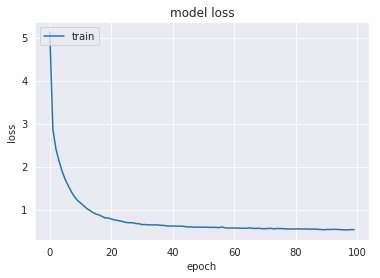

In [27]:
if not multi_epoch_analysis and samples_list == None: 
    
    results = train_nn_and_pred(X_train.values[:,1:], 
                                X_valid.values[:,1:], 
                                X_test.values[:,1:], 
                                y_train.values[:,2:], 
                                y_valid.values[:,2:], 
                                y_test.values[:,2:], 
                                lambda_train_fv_valid_split.values[:,1:], 
                                lambda_train_fv_test_split.values[:,1:], 
                                lambda_train_fv_train_split.values[:,1:], 
                                lambda_valid_fv_valid_split.values[:,1:], 
                                lambda_valid_fv_test_split.values[:,1:], 
                                lambda_valid_fv_train_split.values[:,1:], 
                                lambda_test_fv_valid_split.values[:,1:], 
                                lambda_test_fv_test_split.values[:,1:], 
                                lambda_test_fv_train_split.values[:,1:], 
                                callback_names=['plot_losses_callback', 'early_stopping'], 
                                return_model=True)
    
    history = results[0]
    
    scores_complete = results[1]
    scores_with_valid_fv = scores_complete[0]
    scores_with_test_fv = scores_complete[1]
    
    polynomial_fv_complete = results[2]
    polynomial_valid_fv = polynomial_fv_complete[0]
    polynomial_test_fv = polynomial_fv_complete[1]
    
    model = results[3]
    
    x = PrettyTable()

    x.field_names = ["Error Name", "Valid Error Int", "Test Error Int"]

    for error, value in scores_with_test_fv.items():

        x.add_row([error, value[0], value[1]])

    print(x)    
    
elif multi_epoch_analysis and samples_list == None: 
    
    results_list = Parallel(n_jobs=n_jobs, 
                            verbose=11, 
                            backend='loky')(delayed(train_nn_and_pred)(X_train.values[:,1:], 
                                                                      X_valid.values[:,1:], 
                                                                      X_test.values[:,1:], 
                                                                      y_train.values[:,2:], 
                                                                      y_valid.values[:,2:], 
                                                                      y_test.values[:,2:], 
                                                                      lambda_train_fv_valid_split.values[:,1:], 
                                                                      lambda_train_fv_test_split.values[:,1:], 
                                                                      lambda_train_fv_train_split.values[:,1:], 
                                                                      lambda_valid_fv_valid_split.values[:,1:], 
                                                                      lambda_valid_fv_test_split.values[:,1:], 
                                                                      lambda_valid_fv_train_split.values[:,1:], 
                                                                      lambda_test_fv_valid_split.values[:,1:], 
                                                                      lambda_test_fv_test_split.values[:,1:], 
                                                                      lambda_test_fv_train_split.values[:,1:], 
                                                                      callback_names=['early_stopping']) for X_train, 
                                                                                                               X_valid, 
                                                                                                               X_test, 
                                                                                                               y_train, 
                                                                                                               y_valid, 
                                                                                                               y_test, 
                                                                                                               lambda_train_fv_valid_split, 
                                                                                                               lambda_train_fv_test_split, 
                                                                                                               lambda_train_fv_train_split,                                            
                                                                                                               lambda_valid_fv_valid_split, 
                                                                                                               lambda_valid_fv_test_split, 
                                                                                                               lambda_valid_fv_train_split, 
                                                                                                               lambda_test_fv_valid_split, 
                                                                                                               lambda_test_fv_test_split, 
                                                                                                               lambda_test_fv_train_split in zip(X_train_list, 
                                                                                                                                                 X_valid_list, 
                                                                                                                                                 X_test_list, 
                                                                                                                                                 y_train_list, 
                                                                                                                                                 y_valid_list, 
                                                                                                                                                 y_test_list, 
                                                                                                                                                 lambda_train_fv_valid_split_list, 
                                                                                                                                                 lambda_train_fv_test_split_list, 
                                                                                                                                                 lambda_train_fv_train_split_list,                                                                                                                                                  
                                                                                                                                                 lambda_valid_fv_valid_split_list, 
                                                                                                                                                 lambda_valid_fv_test_split_list, 
                                                                                                                                                 lambda_valid_fv_train_split_list, 
                                                                                                                                                 lambda_test_fv_valid_split_list, 
                                                                                                                                                 lambda_test_fv_test_split_list, 
                                                                                                                                                 lambda_test_fv_train_split_list))      

    history_list = [result[0] for result in results_list]
    
    scores_complete_list = [result[1] for result in results_list]
    scores_with_valid_fv_list = [scores[0] for scores in scores_complete_list]
    scores_with_test_fv_list = [scores[1] for scores in scores_complete_list]
    
    polynomial_fv_complete_list = [result[2] for result in results_list]
    polynomial_valid_fv_list = [polynomial[0] for polynomial in polynomial_fv_complete_list]
    polynomial_test_fv_list = [polynomial[1] for polynomial in polynomial_fv_complete_list]


    for i, history in enumerate(history_list):  
        index = (i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1
        
        plt.plot(history[list(history.keys())[1]])
        if consider_labels_training or evaluate_with_real_function:
            plt.plot(history[list(history.keys())[len(history.keys())//2+1]])
        plt.title('model ' + list(history.keys())[len(history.keys())//2+1])
        plt.ylabel('metric')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/' + list(history.keys())[len(history.keys())//2+1] +  '_' + interpretation_network_string + filename + '_epoch_' + str(index).zfill(3) + '.png')
        plt.clf()
        
        plt.plot(history['loss'])
        if consider_labels_training or evaluate_with_real_function:
            plt.plot(history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_epoch_' + str(index).zfill(3) + '.png')    
        if i < len(history_list)-1:
            plt.clf()
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(history_list, f, protocol=2)   
        
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(scores_with_test_fv_list, f, protocol=2)   
        
elif not multi_epoch_analysis and  samples_list != None:
    
    results_list = Parallel(n_jobs=n_jobs, verbose=11, backend='loky')(delayed(train_nn_and_pred)(X_train.sample(n=samples, random_state=RANDOM_SEED).values[:,1:], 
                                                                                                  X_valid.values[:,1:],
                                                                                                  X_test.values[:,1:], 
                                                                                                  y_train.sample(n=samples, random_state=RANDOM_SEED).values[:,2:], 
                                                                                                  y_valid.values[:,2:], 
                                                                                                  y_test.values[:,2:], 
                                                                                                  lambda_train_fv_valid_split.values[:,1:], 
                                                                                                  lambda_train_fv_test_split.values[:,1:], 
                                                                                                  lambda_train_fv_train_split.values[:,1:], 
                                                                                                  lambda_valid_fv_valid_split.values[:,1:], 
                                                                                                  lambda_valid_fv_test_split.values[:,1:], 
                                                                                                  lambda_valid_fv_train_split.values[:,1:], 
                                                                                                  lambda_test_fv_valid_split.values[:,1:], 
                                                                                                  lambda_test_fv_test_split.values[:,1:], 
                                                                                                  lambda_test_fv_train_split.values[:,1:], 
                                                                                                  callback_names=['early_stopping']) for samples in samples_list)     
    
    history_list = [result[0] for result in results_list]
     
    scores_complete_list = [result[1] for result in results_list]
    scores_with_valid_fv_list = [scores[0] for scores in scores_complete_list]
    scores_with_test_fv_list = [scores[1] for scores in scores_complete_list]
    
    polynomial_fv_complete_list = [result[2] for result in results_list]
    polynomial_valid_fv_list = [polynomial[0] for polynomial in polynomial_fv_complete_list]
    polynomial_test_fv_list = [polynomial[1] for polynomial in polynomial_fv_complete_list]

    for i, history in enumerate(history_list):       
        
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]])
        if consider_labels_training or evaluate_with_real_function:
            plt.plot(history[list(history.keys())[1]])
        plt.title('model ' + list(history.keys())[len(history.keys())//2+1])
        plt.ylabel('metric')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/' + list(history.keys())[len(history.keys())//2+1] +  '_' + interpretation_network_string + filename + '_epoch_' + str(samples_list[i]).zfill(5) + '.png')
        plt.clf()
        
        plt.plot(history['loss'])
        if consider_labels_training or evaluate_with_real_function:
            plt.plot(history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_epoch_' + str(samples_list[i]).zfill(5) + '.png')    
        if i < len(history_list)-1:
            plt.clf()
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(history_list, f, protocol=2)   
        
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(scores_with_test_fv_list, f, protocol=2)     
        

## Evaluate Interpretation Net

In [28]:
printer = None
if multi_epoch_analysis or samples_list != None:
    printer = scores_with_valid_fv_list[-1]
else:
    printer = scores_with_valid_fv
printer

{'MAE': [1.876, 1.8426],
 'RMSE': [3.4533, 3.3817],
 'MAPE': [9.064, 12.184],
 'Accuracy': [0.037, 0.0369],
 'Accuracy Multilabel': [0.0, 0.0],
 'MAE FV': [7.3098, 7.1629, 10.7971, 10.7182],
 'RMSE FV': [9.1273, 8.9083, 13.0648, 12.9736],
 'MAPE FV': [4.6166, 19.4329, 7.2901, 9.3111],
 'R2 FV': [-0.5078, -0.4259, -2.7603, -2.6248],
 'RAAE FV': [0.9342, 0.9124, 1.4749, 1.4513],
 'RMAE FV': [2.9813, 2.8008, 3.475, 3.3725],
 'STD FV PRED': [8.506067439810788,
  8.355701981725383,
  8.506067439810788,
  8.355701981725383],
 'MEAN FV PRED': [-0.688667816011244,
  -0.6805655867588705,
  -0.688667816011244,
  -0.6805655867588705]}

In [29]:
printer = None
if multi_epoch_analysis or samples_list != None:
    printer = scores_with_test_fv_list[-1]
else:
    printer = scores_with_test_fv
printer

{'MAE': [1.876, 1.8426],
 'RMSE': [3.4533, 3.3817],
 'MAPE': [9.064, 12.184],
 'Accuracy': [0.037, 0.0369],
 'Accuracy Multilabel': [0.0, 0.0],
 'MAE FV': [7.2988, 7.179, 10.8071, 10.7011],
 'RMSE FV': [9.1013, 8.9147, 13.0812, 12.9499],
 'MAPE FV': [4.5822, 23.9222, 6.8888, 10.4723],
 'R2 FV': [-0.5134, -0.4305, -2.7754, -2.6456],
 'RAAE FV': [0.9362, 0.9146, 1.4748, 1.4527],
 'RMAE FV': [2.9183, 2.7291, 3.3906, 3.2833],
 'STD FV PRED': [8.493947114376414,
  8.34113831727649,
  8.493947114376414,
  8.34113831727649],
 'MEAN FV PRED': [-0.7258707698961879,
  -0.6689957301806218,
  -0.7258707698961879,
  -0.6689957301806218]}

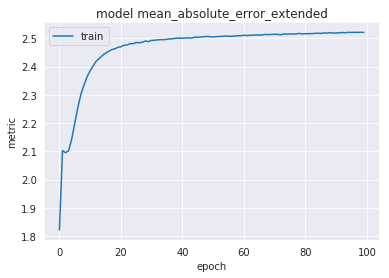

In [30]:
plt.plot(history[list(history.keys())[len(history.keys())//2+1]])
if consider_labels_training or evaluate_with_real_function:
    plt.plot(history[list(history.keys())[1]])
plt.title('model ' + list(history.keys())[len(history.keys())//2+1])
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('./data/results/' + interpretation_network_string + filename + '/metric_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


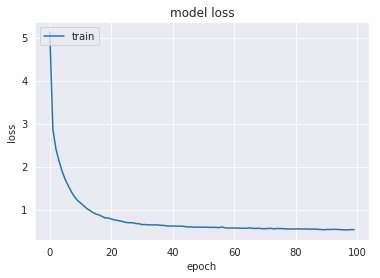

In [31]:
plt.plot(history['loss'])
if consider_labels_training or evaluate_with_real_function:
    plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

In [32]:
if multi_epoch_analysis and samples_list == None: 
    plot_history_loss = []
    plot_history_metric = []
    plot_history_val_loss = []
    plot_history_val_metric = []
        
    for history in history_list:
        plot_history_loss.append(history['loss'][-1])
        plot_history_metric.append(history[list(history.keys())[1]][-1])

        if consider_labels_training or evaluate_with_real_function:
            plot_history_val_loss.append(history['val_loss'][-1])
            plot_history_val_metric.append(history[list(history.keys())[len(history.keys())//2+1]][-1])


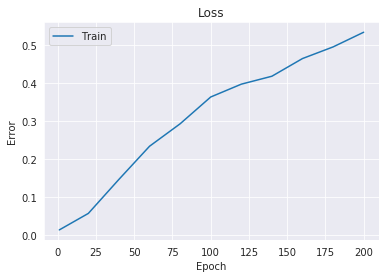

In [33]:
if multi_epoch_analysis and samples_list == None: 
    plot_history_loss_df = pd.DataFrame(data=plot_history_loss, index=[(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in range(len(plot_history_loss))])
    if consider_labels_training or evaluate_with_real_function:
        plot_history_val_loss_df = pd.DataFrame(data=plot_history_val_loss, index=[(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in range(len(plot_history_val_loss))])
    
    plt.plot(plot_history_loss_df)
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(plot_history_val_loss_df)
    plt.title('Loss')
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_total.eps')
    plt.show()

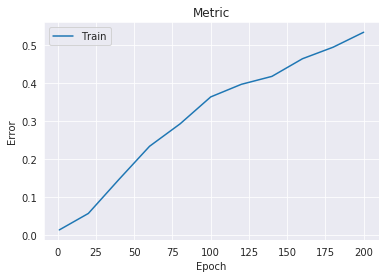

In [34]:
if multi_epoch_analysis and samples_list == None: 
    plot_history_metric_df = pd.DataFrame(data=plot_history_metric, index=[(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in range(len(plot_history_metric))])
    if consider_labels_training or evaluate_with_real_function:
        plot_history_val_metric_df = pd.DataFrame(data=plot_history_val_metric, index=[(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in range(len(plot_history_val_metric))])
    
    plt.plot(plot_history_metric_df)
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(plot_history_val_metric_df)
    plt.title('Metric')
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.savefig('./data/results/' + interpretation_network_string + filename + '/metric_' + interpretation_network_string + filename + '_total.eps')
    plt.show()

#### Structure Interpretation-Net Socres for Plotting

In [35]:
#TODO: CHECK THAT LAMBDA-NET SCORES ARE USED CORRECT, 
#    PRED_EVAL_DATASETS HAVE NO INDEX AND 
#    CORRECT INET PREDS ARE COMPARED WITH LAMBDA PREDS

In [36]:
metrics_coeff_keys = ['MAE', 'RMSE', 'MAPE', 'Accuracy', 'Accuracy Multilabel']
metrics_fv_keys = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

new_row_identifiers_coeff = ['MAE', 'RMSE', 'MAPE', 'ACC', 'ACC MULT']
new_row_identifiers_fv = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

if multi_epoch_analysis and evaluate_with_real_function:

    scores_coeff_valid = []
    scores_coeff_test = []

    scores_valid_list = []
    scores_test_list = []
    stds_list = []    
    means_list = []    
    for i, scores_int in enumerate(scores_with_test_fv_list):
        index = (i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1

        if i == 0:
            scores_coeff_valid = pd.DataFrame([scores_int[score][0] for score in metrics_coeff_keys], columns=['VALID E' + str(index)], index=new_row_identifiers_coeff)
            scores_coeff_test = pd.DataFrame([scores_int[score][1] for score in metrics_coeff_keys], columns=['TEST E' + str(index)], index=new_row_identifiers_coeff)
            
            scores_valid_list = pd.DataFrame([scores_int[score][0] for score in metrics_fv_keys], columns=['VALID PRED E' + str(index)], index=new_row_identifiers_fv)
            scores_test_list = pd.DataFrame([scores_int[score][1] for score in metrics_fv_keys], columns=['TEST PRED E' + str(index)], index=new_row_identifiers_fv)
            
            stds_list = pd.DataFrame(scores_int['STD FV PRED'], columns=['E' + str(index)], index=['STD FUNC VALID PRED', 'STD FUNC TEST PRED'])

            means_list = pd.DataFrame(scores_int['MEAN FV PRED'], columns=['E' + str(index)], index=['MEAN FUNC VALID PRED', 'MEAN FUNC TEST PRED'])
  
        else:
            scores_coeff_valid_new = pd.DataFrame([scores_int[score][0] for score in metrics_coeff_keys], columns=['VALID E' + str(index)], index=new_row_identifiers_coeff)
            scores_coeff_test_new = pd.DataFrame([scores_int[score][1] for score in metrics_coeff_keys], columns=['TEST E' + str(index)], index=new_row_identifiers_coeff)
            
            scores_valid_list_new = pd.DataFrame([scores_int[score][0] for score in metrics_fv_keys], columns=['VALID PRED E' + str(index)], index=new_row_identifiers_fv)
            scores_test_list_new = pd.DataFrame([scores_int[score][1] for score in metrics_fv_keys], columns=['TEST PRED E' + str(index)], index=new_row_identifiers_fv)
                       
            stds_list_new = pd.DataFrame(scores_int['STD FV PRED'], columns=['E' + str(index)], index=['STD FUNC VALID PRED', 'STD FUNC TEST PRED'])
            
            means_list_new = pd.DataFrame(scores_int['MEAN FV PRED'], columns=['E' + str(index)], index=['MEAN FUNC VALID PRED', 'MEAN FUNC TEST PRED'])
            
            
            scores_coeff_valid = pd.concat([scores_coeff_valid, scores_coeff_valid_new],axis=1)  
            scores_coeff_test = pd.concat([scores_coeff_test, scores_coeff_test_new],axis=1)  
            
            scores_valid_list = pd.concat([scores_valid_list, scores_valid_list_new],axis=1)  
            scores_test_list = pd.concat([scores_test_list, scores_test_list_new],axis=1)  

            stds_list = pd.concat([stds_list, stds_list_new],axis=1)
            
            means_list = pd.concat([means_list, means_list_new],axis=1)  


elif multi_epoch_analysis and not evaluate_with_real_function:

    scores_coeff_valid = []
    scores_coeff_test = []


    scores_valid_list = []
    scores_test_list = []
    stds_list = []    
    means_list = []    
    for i, scores_int in enumerate(scores_with_test_fv_list):
        index = (i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1

        if i == 0:
            scores_coeff_valid = pd.DataFrame([scores_int[score][0] for score in metrics_coeff_keys], columns=['VALID E' + str(index)], index=new_row_identifiers_coeff)
            scores_coeff_test = pd.DataFrame([scores_int[score][1] for score in metrics_coeff_keys], columns=['TEST E' + str(index)], index=new_row_identifiers_coeff)
            
            scores_valid_list = pd.DataFrame([[scores_int[score][2], scores_int[score][0]] for score in metrics_fv_keys], columns=['VALID PRED E' + str(index), 'VALID POLY E' + str(index)], index=new_row_identifiers_fv)
            scores_test_list = pd.DataFrame([[scores_int[score][3], scores_int[score][1]] for score in metrics_fv_keys], columns=['TEST PRED E' + str(index), 'TEST POLY E' + str(index)], index=new_row_identifiers_fv)
            
            stds_list = pd.DataFrame(scores_int['STD FV PRED'], columns=['E' + str(index)], index=['STD FUNC VALID PRED', 'STD FUNC TEST PRED', 'std_function_valid_pred_lambda_fv', 'std_function_test_pred_lambda_fv'])
            
            means_list = pd.DataFrame(scores_int['MEAN FV PRED'], columns=['E' + str(index)], index=['MEAN FUNC VALID PRED', 'MEAN FUNC TEST PRED', 'mean_function_valid_pred_lambda_fv', 'mean_function_test_pred_lambda_fv'])
        else:
            scores_coeff_valid_new = pd.DataFrame([scores_int[score][0] for score in metrics_coeff_keys], columns=['VALID E' + str(index)], index=new_row_identifiers_coeff)
            scores_coeff_test_new = pd.DataFrame([scores_int[score][1] for score in metrics_coeff_keys], columns=['TEST E' + str(index)], index=new_row_identifiers_coeff)
            
            scores_valid_list_new = pd.DataFrame([[scores_int[score][2], scores_int[score][0]] for score in metrics_fv_keys], columns=['VALID PRED E' + str(index), 'VALID POLY E' + str(index)], index=new_row_identifiers_fv)
            scores_test_list_new = pd.DataFrame([[scores_int[score][3], scores_int[score][1]] for score in metrics_fv_keys], columns=['TEST PRED E' + str(index), 'TEST POLY E' + str(index)], index=new_row_identifiers_fv)
                       
            stds_list_new = pd.DataFrame(scores_int['STD FV PRED'], columns=['E' + str(index)], index=['STD FUNC VALID PRED', 'STD FUNC TEST PRED', 'std_function_valid_pred_lambda_fv', 'std_function_test_pred_lambda_fv'])
            
            means_list_new = pd.DataFrame(scores_int['MEAN FV PRED'], columns=['E' + str(index)], index=['MEAN FUNC VALID PRED', 'MEAN FUNC TEST PRED', 'mean_function_valid_pred_lambda_fv', 'means_function_test_pred_lambda_fv'])
            
            
            scores_coeff_valid = pd.concat([scores_coeff_valid, scores_coeff_valid_new],axis=1)  
            scores_coeff_test = pd.concat([scores_coeff_test, scores_coeff_test_new],axis=1)  
            
            scores_valid_list = pd.concat([scores_valid_list, scores_valid_list_new],axis=1)  
            scores_test_list = pd.concat([scores_test_list, scores_test_list_new],axis=1)  

            stds_list = pd.concat([stds_list, stds_list_new],axis=1)  
            
            means_list = pd.concat([means_list, means_list_new],axis=1)  
    
elif not multi_epoch_analysis and samples_list != None and evaluate_with_real_function:
    scores_coeff_valid = []
    scores_coeff_test = []


    scores_valid_list = []
    scores_test_list = []
    stds_list = []    
    means_list = []    

    for index, scores_int in enumerate(scores_with_test_fv_list):
        index = samples_list[index]
        
        if index == samples_list[0]:
            scores_coeff_valid = pd.DataFrame([scores_int[score][0] for score in metrics_coeff_keys], columns=['VALID S' + str(index)], index=new_row_identifiers_coeff)
            scores_coeff_test = pd.DataFrame([scores_int[score][1] for score in metrics_coeff_keys], columns=['TEST S' + str(index)], index=new_row_identifiers_coeff)
            
            scores_valid_list = pd.DataFrame([scores_int[score][0] for score in metrics_fv_keys], columns=['VALID PRED S' + str(index)], index=new_row_identifiers_fv)
            scores_test_list = pd.DataFrame([scores_int[score][1] for score in metrics_fv_keys], columns=['TEST PRED S' + str(index)], index=new_row_identifiers_fv)
            
            stds_list = pd.DataFrame(scores_int['STD FV PRED'], columns=['S' + str(index)], index=['STD FUNC VALID PRED', 'STD FUNC TEST PRED'])
            
            means_list = pd.DataFrame(scores_int['MEAN FV PRED'], columns=['S' + str(index)], index=['MEAN FUNC VALID PRED', 'MEAN FUNC TEST PRED'])
        else:
            scores_coeff_valid_new = pd.DataFrame([scores_int[score][0] for score in metrics_coeff_keys], columns=['VALID S' + str(index)], index=new_row_identifiers_coeff)
            scores_coeff_test_new = pd.DataFrame([scores_int[score][1] for score in metrics_coeff_keys], columns=['TEST S' + str(index)], index=new_row_identifiers_coeff)
            
            scores_valid_list_new = pd.DataFrame([scores_int[score][0] for score in metrics_fv_keys], columns=['VALID PRED S' + str(index)], index=new_row_identifiers_fv)
            scores_test_list_new = pd.DataFrame([scores_int[score][1] for score in metrics_fv_keys], columns=['TEST PRED S' + str(index)], index=new_row_identifiers_fv)
                       
            stds_list_new = pd.DataFrame(scores_int['STD FV PRED'], columns=['S' + str(index)], index=['STD FUNC VALID PRED', 'STD FUNC TEST PRED'])
            
            means_list_new = pd.DataFrame(scores_int['MEAN FV PRED'], columns=['S' + str(index)], index=['MEAN FUNC VALID PRED', 'MEAN FUNC TEST PRED'])

            
            scores_coeff_valid = pd.concat([scores_coeff_valid, scores_coeff_valid_new],axis=1)  
            scores_coeff_test = pd.concat([scores_coeff_test, scores_coeff_test_new],axis=1)  
            
            scores_valid_list = pd.concat([scores_valid_list, scores_valid_list_new],axis=1)  
            scores_test_list = pd.concat([scores_test_list, scores_test_list_new],axis=1)  

            stds_list = pd.concat([stds_list, stds_list_new],axis=1) 
            
            means_list = pd.concat([means_list, means_list_new],axis=1)     
            
elif not multi_epoch_analysis and  samples_list != None and not evaluate_with_real_function:

    scores_coeff_valid = []
    scores_coeff_test = []


    scores_valid_list = []
    scores_test_list = []
    stds_list = []    
    means_list = []    
    for index, scores_int in enumerate(scores_with_test_fv_list):
        index = samples_list[index]

        if index == samples_list[0]:
            scores_coeff_valid = pd.DataFrame([scores_int[score][0] for score in metrics_coeff_keys], columns=['VALID S' + str(index)], index=new_row_identifiers_coeff)
            scores_coeff_test = pd.DataFrame([scores_int[score][1] for score in metrics_coeff_keys], columns=['TEST S' + str(index)], index=new_row_identifiers_coeff)
            
            scores_valid_list = pd.DataFrame([[scores_int[score][2], scores_int[score][0]] for score in metrics_fv_keys], columns=['VALID PRED S' + str(index), 'VALID POLY S' + str(index)], index=new_row_identifiers_fv)
            scores_test_list = pd.DataFrame([[scores_int[score][3], scores_int[score][1]] for score in metrics_fv_keys], columns=['TEST PRED S' + str(index), 'TEST POLY S' + str(index)], index=new_row_identifiers_fv)
            
            stds_list = pd.DataFrame(scores_int['STD FV PRED'], columns=['S' + str(index)], index=['STD FUNC VALID PRED', 'STD FUNC TEST PRED', 'std_function_valid_pred_lambda_fv', 'std_function_test_pred_lambda_fv'])
            
            means_list = pd.DataFrame(scores_int['MEAN FV PRED'], columns=['S' + str(index)], index=['MEAN FUNC VALID PRED', 'MEAN FUNC TEST PRED', 'mean_function_valid_pred_lambda_fv', 'mean_function_test_pred_lambda_fv'])

        else:
            scores_coeff_valid_new = pd.DataFrame([scores_int[score][0] for score in metrics_coeff_keys], columns=['VALID S' + str(index)], index=['MAE', 'RMSE', 'MAPE', 'ACC', 'ACC MULT'])
            scores_coeff_test_new = pd.DataFrame([scores_int[score][1] for score in metrics_coeff_keys], columns=['TEST S' + str(index)], index=['MAE', 'RMSE', 'MAPE', 'ACC', 'ACC MULT'])
            
            scores_valid_list_new = pd.DataFrame([[scores_int[score][2], scores_int[score][0]] for score in metrics_fv_keys], columns=['VALID PRED S' + str(index), 'VALID POLY S' + str(index)], index=new_row_identifiers_fv)
            scores_test_list_new = pd.DataFrame([[scores_int[score][3], scores_int[score][1]] for score in metrics_fv_keys], columns=['TEST PRED S' + str(index), 'TEST POLY S' + str(index)], index=new_row_identifiers_fv)
                       
            stds_list_new = pd.DataFrame(scores_int['STD FV PRED'], columns=['S' + str(index)], index=['STD FUNC VALID PRED', 'STD FUNC TEST PRED', 'std_function_valid_pred_lambda_fv', 'std_function_test_pred_lambda_fv'])

            means_list_new = pd.DataFrame(scores_int['MEAN FV PRED'], columns=['S' + str(index)], index=['MEAN FUNC VALID PRED', 'MEAN FUNC TEST PRED', 'mean_function_valid_pred_lambda_fv', 'mean_function_test_pred_lambda_fv'])
            
            
            scores_coeff_valid = pd.concat([scores_coeff_valid, scores_coeff_valid_new],axis=1)  
            scores_coeff_test = pd.concat([scores_coeff_test, scores_coeff_test_new],axis=1)  
            
            scores_valid_list = pd.concat([scores_valid_list, scores_valid_list_new],axis=1)  
            scores_test_list = pd.concat([scores_test_list, scores_test_list_new],axis=1)  

            stds_list = pd.concat([stds_list, stds_list_new],axis=1)      
            
            means_list = pd.concat([means_list, means_list_new],axis=1)    
            
if multi_epoch_analysis:            
    path_scores_valid_coef_int = './data/results/' + interpretation_network_string + filename + '/scores_valid_multiepoch_coef_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'
    path_scores_test_coef_int = './data/results/' + interpretation_network_string + filename + '/scores_test_multiepoch_coef_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'

    path_scores_valid_int = './data/results/' + interpretation_network_string + filename + '/scores_valid_multiepoch_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'
    path_scores_test_int = './data/results/' + interpretation_network_string + filename + '/scores_test_multiepoch_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'

    path_stds_int = './data/results/' + interpretation_network_string + filename + '/stds_multiepoch_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'

    path_means_int = './data/results/' + interpretation_network_string + filename + '/means_multiepoch_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'


    scores_coeff_valid.to_csv(path_scores_valid_coef_int, sep=',')
    scores_coeff_test.to_csv(path_scores_test_coef_int, sep=',') 

    scores_valid_list.to_csv(path_scores_valid_int, sep=',')
    scores_test_list.to_csv(path_scores_test_int, sep=',')

    stds_list.to_csv(path_stds_int, sep=',')  
    means_list.to_csv(path_means_int, sep=',')  
elif samples_list != None:            
    path_scores_valid_coef_int = './data/results/' + interpretation_network_string + filename + '/scores_valid_samples_coef_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'
    path_scores_test_coef_int = './data/results/' + interpretation_network_string + filename + '/scores_test_samples_coef_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'

    path_scores_valid_int = './data/results/' + interpretation_network_string + filename + '/scores_samples_valid_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'
    path_scores_test_int = './data/results/' + interpretation_network_string + filename + '/scores_samples_test_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'

    path_stds_int = './data/results/' + interpretation_network_string + filename + '/stds_samples_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'

    path_means_int = './data/results/' + interpretation_network_string + filename + '/means_samples_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'


    scores_coeff_valid.to_csv(path_scores_valid_coef_int, sep=',')
    scores_coeff_test.to_csv(path_scores_test_coef_int, sep=',') 

    scores_valid_list.to_csv(path_scores_valid_int, sep=',')
    scores_test_list.to_csv(path_scores_test_int, sep=',')

    stds_list.to_csv(path_stds_int, sep=',')  
    means_list.to_csv(path_means_int, sep=',')      

#### Load Lambda Scores for Plotting

In [37]:
'''
TODO: LAMBDA ERRORS ARE BASED ON ALL LAMBDA NETS INSTEAD OF JUST THE LAMBDA NETS IN I-NET TEST SET \n
--> add splits/make preds directly in I-Net code for evaluation
'''

path_scores_valid_lambda = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/scores_valid_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
path_scores_test_lambda = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/scores_test_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
path_stds_lambda = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/stds_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
path_means_lambda = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/means_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'


df_mean_scores_valid_lambda = pd.read_csv(path_scores_valid_lambda, sep=',', index_col=0)
df_mean_scores_test_lambda = pd.read_csv(path_scores_test_lambda, sep=',', index_col=0)
df_stds_lambda = pd.read_csv(path_stds_lambda, sep=',', index_col=0)
df_means_lambda = pd.read_csv(path_means_lambda, sep=',', index_col=0)


In [38]:
df_mean_scores_test_lambda

,TEST PRED E1,TEST POLY E1,TEST POLY PRED E1,TEST LSTSQ E1,TEST PRED E10,TEST POLY E10,TEST POLY PRED E10,TEST LSTSQ E10,TEST PRED E20,TEST POLY E20,TEST POLY PRED E20,TEST LSTSQ E20,TEST PRED E30,TEST POLY E30,TEST POLY PRED E30,TEST LSTSQ E30,TEST PRED E40,TEST POLY E40,TEST POLY PRED E40,TEST LSTSQ E40,TEST PRED E50,TEST POLY E50,TEST POLY PRED E50,TEST LSTSQ E50,TEST PRED E60,TEST POLY E60,TEST POLY PRED E60,TEST LSTSQ E60,TEST PRED E70,TEST POLY E70,TEST POLY PRED E70,TEST LSTSQ E70,TEST PRED E80,TEST POLY E80,TEST POLY PRED E80,TEST LSTSQ E80,TEST PRED E90,TEST POLY E90,TEST POLY PRED E90,TEST LSTSQ E90,TEST PRED E100,TEST POLY E100,TEST POLY PRED E100,TEST LSTSQ E100,TEST PRED E110,TEST POLY E110,TEST POLY PRED E110,TEST LSTSQ E110,TEST PRED E120,TEST POLY E120,TEST POLY PRED E120,TEST LSTSQ E120,TEST PRED E130,TEST POLY E130,TEST POLY PRED E130,TEST LSTSQ E130,TEST PRED E140,TEST POLY E140,TEST POLY PRED E140,TEST LSTSQ E140,TEST PRED E150,TEST POLY E150,TEST POLY PRED E150,TEST LSTSQ E150,TEST PRED E160,TEST POLY E160,TEST POLY PRED E160,TEST LSTSQ E160,TEST PRED E170,TEST POLY E170,TEST POLY PRED E170,TEST LSTSQ E170,TEST PRED E180,TEST POLY E180,TEST POLY PRED E180,TEST LSTSQ E180,TEST PRED E190,TEST POLY E190,TEST POLY PRED E190,TEST LSTSQ E190,TEST PRED E200,TEST POLY E200,TEST POLY PRED E200,TEST LSTSQ E200
MAE FV,10.189,10.189,0.014,0.000,9.701,9.701,0.017,0.000,8.947,8.948,0.024,0.000,7.994,7.996,0.037,0.000,7.231,7.232,0.057,0.000,6.656,6.657,0.085,0.000,6.224,6.225,0.112,0.000,5.908,5.909,0.137,0.000,5.677,5.678,0.161,0.000,5.501,5.502,0.184,0.000,5.361,5.363,0.206,0.000,5.245,5.248,0.227,0.000,5.143,5.147,0.249,0.000,5.048,5.054,0.271,0.000,4.958,4.966,0.294,0.000,4.870,4.880,0.317,0.000,4.783,4.795,0.340,0.000,4.698,4.711,0.364,0.000,4.613,4.627,0.389,0.000,4.529,4.543,0.413,0.000,4.446,4.461,0.437,0.000
RMSE FV,12.975,12.975,0.018,0.000,12.470,12.470,0.022,0.000,11.687,11.687,0.033,0.000,10.644,10.644,0.051,0.000,9.752,9.751,0.080,0.000,9.062,9.060,0.116,0.000,8.530,8.527,0.154,0.000,8.128,8.124,0.190,0.000,7.825,7.819,0.225,0.000,7.590,7.582,0.257,0.000,7.402,7.392,0.286,0.000,7.245,7.232,0.313,0.000,7.108,7.092,0.340,0.000,6.982,6.963,0.366,0.000,6.864,6.842,0.393,0.000,6.750,6.725,0.420,0.000,6.639,6.609,0.448,0.000,6.529,6.496,0.477,0.000,6.421,6.384,0.507,0.000,6.314,6.272,0.537,0.000,6.209,6.162,0.567,0.000
MAPE FV,1.350,1.348,0.268,0.000,1.496,1.497,0.186,0.000,2.002,2.002,0.396,0.000,2.758,2.754,0.155,0.000,3.280,3.278,0.129,0.000,3.448,3.458,0.146,0.000,3.471,3.475,0.515,0.000,3.444,3.436,0.215,0.000,3.410,3.408,0.293,0.000,3.397,3.413,0.363,0.000,3.392,3.412,0.278,0.000,3.380,3.403,0.371,0.000,3.357,3.379,0.483,0.000,3.336,3.357,0.398,0.000,3.321,3.345,0.420,0.000,3.310,3.335,0.429,0.000,3.293,3.318,0.433,0.000,3.278,3.301,0.492,0.000,3.260,3.278,0.463,0.000,3.240,3.253,0.636,0.000,3.232,3.240,0.842,0.000
R2 FV,-0.423,-0.423,0.999,1.000,-0.300,-0.300,0.999,1.000,-0.123,-0.123,0.999,1.000,0.075,0.075,0.999,1.000,0.216,0.216,0.999,1.000,0.313,0.313,0.999,1.000,0.382,0.383,0.999,1.000,0.433,0.433,0.999,1.000,0.470,0.471,0.998,1.000,0.498,0.499,0.998,1.000,0.521,0.522,0.998,1.000,0.540,0.541,0.998,1.000,0.556,0.557,0.997,1.000,0.570,0.572,0.997,1.000,0.584,0.586,0.997,1.000,0.597,0.599,0.996,1.000,0.609,0.612,0.996,1.000,0.621,0.625,0.995,1.000,0.633,0.637,0.995,1.000,0.645,0.649,0.994,1.000,0.656,0.660,0.994,1.000
RAAE FV,0.925,0.925,0.024,0.000,0.879,0.879,0.025,0.000,0.807,0.807,0.025,0.000,0.720,0.720,0.024,0.000,0.653,0.653,0.024,0.000,0.604,0.605,0.025,0.000,0.568,0.568,0.026,0.000,0.541,0.541,0.027,0.000,0.521,0.522,0.028,0.000,0.506,0.506,0.030,0.000,0.494,0.494,0.032,0.000,0.484,0.484,0.034,0.000,0.475,0.475,0.036,0.000,0.466,0.467,0.039,0.000,0.458,0.459,0.041,0.000,0.450,0.451,0.044,0.000,0.442,0.443,0.047,0.000,0.434,0.436,0.049,0.000,0.427,0.428,0.052,0.000,0.419,0.421,0.055,0.000,0.412,0.413,0.058,0.000
RMAE FV,3.167,3.166,0.100,0.000,3.140,3.140,0.117,0.000,3.092,3.092,0.132,0.000,3.00

In [39]:
df_stds_lambda

,E1,E10,E20,E30,E40,E50,E60,E70,E80,E90,E100,E110,E120,E130,E140,E150,E160,E170,E180,E190,E200
STD FV TRAIN REAL LAMBDA,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156
STD FV TRAIN PRED LAMBDA,0.574,0.673,1.034,1.706,2.614,3.584,4.482,5.244,5.854,6.328,6.690,6.966,7.178,7.346,7.482,7.598,7.699,7.790,7.875,7.956,8.034
STD FV TRAIN PRED LAMBDA POLY LSTSQ,0.574,0.672,1.033,1.706,2.613,3.582,4.480,5.241,5.850,6.323,6.685,6.960,7.171,7.337,7.473,7.587,7.686,7.776,7.860,7.938,8.015
STD FV TRAIN REAL LAMBDA POLY LSTSQ,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156,11.156
STD FV VALID REAL LAMBDA,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129
STD FV VALID PRED LAMBDA,0.574,0.671,1.029,1.696,2.596,3.560,4.453,5.211,5.818,6.290,6.652,6.926,7.137,7.303,7.438,7.552,7.651,7.741,7.824,7.903,7.979
STD FV VALID PRED LAMBDA POLY LSTSQ,0.574,0.671,1.028,1.695,2.595,3.558,4.451,5.208,5.815,6.287,6.647,6.921,7.131,7.296,7.431,7.544,7.642,7.731,7.814,7.891,7.966
STD FV VALID REAL LAMBDA POLY LSTSQ,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129,11.129
STD FV TEST REAL LAMBDA,11.133,11.133,11.133,11.133,11.133,11.133,11.133,11.133,11.133,11.133,11.133,11.133,11.133,11.133,11.133,11.133,11.133,11.133,11.133,11.133,11.133
STD FV TEST PRED LAMBDA,0.574,0.671,1.030,1.697,2.597,3.560,4.454,5.212,5.820,6.292,6.653,6.928,7.138,7.305,7.440,7.554,7.653,7.743,7.826,7.905,7.981


In [40]:
df_means_lambda

,E1,E10,E20,E30,E40,E50,E60,E70,E80,E90,E100,E110,E120,E130,E140,E150,E160,E170,E180,E190,E200
MEAN FV TRAIN REAL LAMBDA,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080
MEAN FV TRAIN PRED LAMBDA,-0.002,-0.011,-0.029,-0.051,-0.066,-0.071,-0.067,-0.065,-0.064,-0.065,-0.064,-0.063,-0.062,-0.062,-0.062,-0.063,-0.063,-0.064,-0.064,-0.064,-0.064
MEAN FV TRAIN PRED LAMBDA POLY LSTSQ,-0.002,-0.011,-0.029,-0.051,-0.066,-0.071,-0.067,-0.065,-0.064,-0.065,-0.064,-0.063,-0.062,-0.062,-0.062,-0.063,-0.063,-0.064,-0.064,-0.064,-0.064
MEAN FV TRAIN REAL LAMBDA POLY LSTSQ,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080,-0.080
MEAN FV VALID REAL LAMBDA,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075
MEAN FV VALID PRED LAMBDA,-0.001,-0.010,-0.028,-0.050,-0.064,-0.068,-0.063,-0.060,-0.059,-0.059,-0.057,-0.056,-0.056,-0.055,-0.056,-0.056,-0.057,-0.057,-0.057,-0.057,-0.057
MEAN FV VALID PRED LAMBDA POLY LSTSQ,-0.001,-0.010,-0.028,-0.050,-0.064,-0.068,-0.063,-0.060,-0.059,-0.058,-0.057,-0.056,-0.056,-0.056,-0.056,-0.056,-0.057,-0.057,-0.057,-0.057,-0.058
MEAN FV VALID REAL LAMBDA POLY LSTSQ,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075,-0.075
MEAN FV TEST REAL LAMBDA,-0.077,-0.077,-0.077,-0.077,-0.077,-0.077,-0.077,-0.077,-0.077,-0.077,-0.077,-0.077,-0.077,-0.077,-0.077,-0.077,-0.077,-0.077,-0.077,-0.077,-0.077
MEAN FV TEST PRED LAMBDA,-0.002,-0.012,-0.030,-0.053,-0.069,-0.073,-0.068,-0.065,-0.064,-0.064,-0.062,-0.061,-0.060,-0.060,-0.060,-0.060,-0.061,-0.061,-0.061,-0.061,-0.061


### Select Columns to Plot

In [41]:
if multi_epoch_analysis:   
    select_columns = []

    for column in df_mean_scores_test_lambda.columns:
        if int(column.split(' ')[-1][1:]) in [(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda]:
            select_columns.append(column)
    
    'Reduce the dfs to equal keys for plotting comparison'
    plot_cols = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']
    scores_lambda = df_mean_scores_test_lambda[select_columns].loc[plot_cols]
    scores_int = scores_test_list.loc[plot_cols]    
elif samples_list != None:
    'Reduce the dfs to equal keys for plotting comparison'
    plot_cols = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']
    scores_int = scores_test_list.loc[plot_cols] 
    scores_lambda = df_mean_scores_test_lambda.loc[plot_cols].iloc[:,-4:]

In [42]:
print_head = None
if multi_epoch_analysis or samples_list != None:
    print_head = scores_int
print_head

,TEST PRED E1,TEST POLY E1,TEST PRED E20,TEST POLY E20,TEST PRED E40,TEST POLY E40,TEST PRED E60,TEST POLY E60,TEST PRED E80,TEST POLY E80,TEST PRED E100,TEST POLY E100,TEST PRED E120,TEST POLY E120,TEST PRED E140,TEST POLY E140,TEST PRED E160,TEST POLY E160,TEST PRED E180,TEST POLY E180,TEST PRED E200,TEST POLY E200
MAE FV,0.383,0.362,3.021,0.984,7.915,2.688,9.434,4.471,10.011,5.674,10.517,5.905,10.656,6.542,10.729,6.808,10.792,7.386,11.038,7.027,10.701,7.179
RMSE FV,0.468,0.440,3.309,1.190,8.720,3.233,10.771,5.396,11.774,6.894,12.480,7.210,12.746,8.023,12.922,8.404,13.037,9.126,13.261,8.749,12.950,8.915
MAPE FV,3.994,1.692,10.720,3.521,12.750,4.542,10.087,8.099,14.577,6.203,13.336,6.854,8.387,5.143,10.110,5.847,16.269,6.081,6.519,116.582,10.472,23.922
R2 FV,0.333,0.409,-16.757,-0.560,-42.143,-1.762,-19.017,-1.037,-12.866,-1.015,-5.793,-0.485,-4.168,-0.528,-3.552,-0.534,-3.364,-0.668,-3.101,-0.458,-2.646,-0.430
RAAE FV,0.662,0.628,3.171,0.981,4.115,1.229,2.735,1.070,2.225,1.045,1.846,0.917,1.681,0.933,1.596,0.931,1.550,0.976,1.537,0.915,1.453,0.915
RMAE FV,1.956,1.955,3.613,2.494,4.356,2.771,4.147,2.682,3.954,2.703,3.477,2.469,3.289,2.491,3.419,2.679,3.450,2.833,3.244,2.712,3.283,2.729


In [43]:
lambda_test_fv_test_split.head()

,0,FV_1,FV_2,FV_3,FV_4,FV_5,FV_6,FV_7,FV_8,FV_9,FV_10,FV_11,FV_12,FV_13,FV_14,FV_15,FV_16,FV_17,FV_18,FV_19,FV_20,FV_21,FV_22,FV_23,FV_24,FV_25,FV_26,FV_27,FV_28,FV_29,FV_30,FV_31,FV_32,FV_33,FV_34,FV_35,FV_36,FV_37,FV_38,FV_39,FV_40,FV_41,FV_42,FV_43,FV_44,FV_45,FV_46,FV_47,FV_48,FV_49,FV_50,FV_51,FV_52,FV_53,FV_54,FV_55,FV_56,FV_57,FV_58,FV_59,FV_60,FV_61,FV_62,FV_63,FV_64,FV_65,FV_66,FV_67,FV_68,FV_69,FV_70,FV_71,FV_72,FV_73,FV_74,FV_75,FV_76,FV_77,FV_78,FV_79,FV_80,FV_81,FV_82,FV_83,FV_84,FV_85,FV_86,FV_87,FV_88,FV_89,FV_90,FV_91,FV_92,FV_93,FV_94,FV_95,FV_96,FV_97,FV_98,FV_99,FV_100,FV_101,FV_102,FV_103,FV_104,FV_105,FV_106,FV_107,FV_108,FV_109,FV_110,FV_111,FV_112,FV_113,FV_114,FV_115,FV_116,FV_117,FV_118,FV_119,FV_120,FV_121,FV_122,FV_123,FV_124,FV_125,FV_126,FV_127,FV_128,FV_129,FV_130,FV_131,FV_132,FV_133,FV_134,FV_135,FV_136,FV_137,FV_138,FV_139,FV_140,FV_141,FV_142,FV_143,FV_144,FV_145,FV_146,FV_147,FV_148,FV_149,FV_150,FV_151,FV_152,FV_153,FV_154,FV_155,FV_156,FV_157,FV_158,FV_159,FV_160,FV_161,FV_162,FV_163,FV_164,FV_165,FV_166,FV_167,FV_168,FV_169,FV_170,FV_171,FV_172,FV_173,FV_174,FV_175,FV_176,FV_177,FV_178,FV_179,FV_180,FV_181,FV_182,FV_183,FV_184,FV_185,FV_186,FV_187,FV_188,FV_189,FV_190,FV_191,FV_192,FV_193,FV_194,FV_195,FV_196,FV_197,FV_198,FV_199,FV_200,FV_201,FV_202,FV_203,FV_204,FV_205,FV_206,FV_207,FV_208,FV_209,FV_210,FV_211,FV_212,FV_213,FV_214,FV_215,FV_216,FV_217,FV_218,FV_219,FV_220,FV_221,FV_222,FV_223,FV_224,FV_225,FV_226,FV_227,FV_228,FV_229,FV_230,FV_231,FV_232,FV_233,FV_234,FV_235,FV_236,FV_237,FV_238,FV_239,FV_240,FV_241,FV_242,FV_243,FV_244,FV_245,FV_246,FV_247,FV_248,FV_249,FV_250
4,8397,-5.847,-11.983,-3.959,-0.750,-0.092,-2.920,-0.097,-4.039,-1.441,-4.206,-5.093,-0.631,-9.417,-4.658,-3.259,-6.497,-5.795,-4.019,-6.529,-1.430,-7.847,-1.836,2.014,-3.532,-6.141,-2.567,-0.630,-1.301,1.018,-2.634,-11.124,-0.986,-5.286,-2.514,-4.883,-7.818,-0.305,-2.261,-3.424,-1.184,-3.269,-1.727,-5.015,-11.100,-2.155,-4.997,-2.287,1.836,-3.825,-12.182,-0.893,3.361,-0.894,-1.438,-0.569,-1.878,-4.198,2.493,-3.137,1.931,-11.312,-8.574,-2.989,4.374,-13.243,3.264,-11.483,-4.082,-0.984,-4.444,-13.774,-2.053,-0.261,0.187,-8.693,-1.478,-6.352,-4.865,-3.842,2.760,-3.507,-1.297,-1.824,-3.705,-8.986,0.155,-2.850,-4.581,0.321,-1.285,-8.639,3.151,-7.010,-0.808,-4.951,-4.210,-2.565,-6.987,5.667,-7.169,-0.963,5.026,-2.923,-2.790,-8.070,-3.801,4.004,-9.079,-4.185,-3.051,1.850,2.372,-4.783,-9.542,-4.228,-0.878,-3.298,-4.344,-5.570,0.917,3.386,-2.350,-7.231,-3.024,-5.087,4.925,3.512,-4.768,-0.045,-5.432,-9.400,1.091,1.800,-6.931,-3.666,-4.624,-4.442,-4.614,-7.733,-4.181,-7.124,-0.499,5.474,-6.109,-3.651,-2.687,-1.507,6.782,-2.878,-1.079,-1.265,-3.551,-10.399,-5.014,0.245,1.330,1.877,-1.515,-4.881,-4.574,-10.244,-3.430,-4.347,-3.808,-3.090,1.067,-4.852,7.650,-12.136,-1.307,-2.304,-2.690,0.798,1.084,-2.913,-3.333,-0.722,-8.206,-3.005,-6.563,-2.115,-6.774,-5.738,-5.575,-3.813,-8.858,-7.070,6.104,-3.034,-4.119,-1.799,-2.392,-11.803,-4.054,0.940,-3.123,-2.230,-1.979,-3.497,-3.600,-2.897,5.451,-7.573,-2.995,-0.045,3.753,7.574,2.666,-0.292,-2.671,-4.070,-4.472,-10.219,3.087,0.844,-0.830,1.587,-1.090,-0.684,-2.430,-2.657,-4.351,-0.136,-5.184,-0.857,-0.229,4.600,-6.641,4.320,-12.365,-2.475,-3.732,-1.007,-1.663,-0.392,-10.467,-1.601,-6.278,-6.165,0.277,-1.598,-5.397,-5.071,-3.386,-7.570,-5.654,-4.045,-1.861,-2.068,-1.267
9,4895,-6.270,13.132,9.765,-5.702,-9.330,-0.656,-21.910,0.519,12.767,0.683,2.397,18.795,9.489,11.980,8.984,-4.730,9.226,-3.836,21.397,3.857,8.502,15.378,21.584,4.147,-3.072,4.631,-15.732,-10.103,-8.400,8.278,18.010,1.891,5.203,-1.547,3.876,20.065,-2.262,1.841,9.096,9.326,-0.586,3.782,10.485,20.983,-6.991,17.051,11.069,16.609,11.115,9.783,-15.661,-3.564,16.545,13.819,0.119,-16.569,8.920,25.870,-1.461,-19.301,-7.496,-7.488,-3.227,5.858,9.247,-12.620,6.659,19.083,6.051,1.727,-10.460,2.458,0.789,20.874,8.222,12.005,-2.442,5.041,5.486,-1.167,9.948,-4.151,1.513,11.659,10.557,6.238,-6.273,-0.577,4.449,-8.913,7.529,10.390,-22.22

In [44]:
lambda_valid_fv_test_split.head()

,0,FV_1,FV_2,FV_3,FV_4,FV_5,FV_6,FV_7,FV_8,FV_9,FV_10,FV_11,FV_12,FV_13,FV_14,FV_15,FV_16,FV_17,FV_18,FV_19,FV_20,FV_21,FV_22,FV_23,FV_24,FV_25,FV_26,FV_27,FV_28,FV_29,FV_30,FV_31,FV_32,FV_33,FV_34,FV_35,FV_36,FV_37,FV_38,FV_39,FV_40,FV_41,FV_42,FV_43,FV_44,FV_45,FV_46,FV_47,FV_48,FV_49,FV_50,FV_51,FV_52,FV_53,FV_54,FV_55,FV_56,FV_57,FV_58,FV_59,FV_60,FV_61,FV_62,FV_63,FV_64,FV_65,FV_66,FV_67,FV_68,FV_69,FV_70,FV_71,FV_72,FV_73,FV_74,FV_75,FV_76,FV_77,FV_78,FV_79,FV_80,FV_81,FV_82,FV_83,FV_84,FV_85,FV_86,FV_87,FV_88,FV_89,FV_90,FV_91,FV_92,FV_93,FV_94,FV_95,FV_96,FV_97,FV_98,FV_99,FV_100,FV_101,FV_102,FV_103,FV_104,FV_105,FV_106,FV_107,FV_108,FV_109,FV_110,FV_111,FV_112,FV_113,FV_114,FV_115,FV_116,FV_117,FV_118,FV_119,FV_120,FV_121,FV_122,FV_123,FV_124,FV_125,FV_126,FV_127,FV_128,FV_129,FV_130,FV_131,FV_132,FV_133,FV_134,FV_135,FV_136,FV_137,FV_138,FV_139,FV_140,FV_141,FV_142,FV_143,FV_144,FV_145,FV_146,FV_147,FV_148,FV_149,FV_150,FV_151,FV_152,FV_153,FV_154,FV_155,FV_156,FV_157,FV_158,FV_159,FV_160,FV_161,FV_162,FV_163,FV_164,FV_165,FV_166,FV_167,FV_168,FV_169,FV_170,FV_171,FV_172,FV_173,FV_174,FV_175,FV_176,FV_177,FV_178,FV_179,FV_180,FV_181,FV_182,FV_183,FV_184,FV_185,FV_186,FV_187,FV_188
4,8397,-1.688,-8.651,-0.325,0.073,-3.823,1.021,-2.619,-1.212,-9.965,-1.471,-4.699,-2.117,2.449,-4.797,-10.470,2.794,-4.834,-0.856,-3.552,-4.666,-3.374,-5.500,-1.932,-3.078,0.201,3.371,-3.028,-2.125,3.842,0.230,-1.204,-4.702,-7.740,-2.823,-1.482,-2.308,-9.651,-5.435,1.903,-3.037,1.011,-10.317,-4.833,-2.360,-2.154,1.912,-7.609,-0.785,-3.741,-4.723,-0.734,4.404,-4.855,5.057,2.019,-4.303,-4.237,-12.370,1.681,-2.568,-1.930,-0.790,-6.012,-9.690,-1.550,-2.823,2.581,-3.380,-10.807,-1.365,-9.281,-0.426,-0.637,-5.634,2.905,-3.421,-3.449,-7.522,-7.084,1.736,-0.569,-0.044,-5.017,-4.945,-10.267,-5.176,2.149,-5.710,-8.329,-4.762,1.153,-6.330,-5.690,-5.382,-1.736,-3.421,-2.280,1.052,-5.235,-3.281,-2.005,5.880,-5.748,-4.118,-3.990,-0.602,5.495,-1.151,-5.150,-3.651,1.067,-5.729,-6.456,-7.404,-6.705,-1.803,-0.829,0.032,-3.066,-8.220,-0.030,-7.114,1.135,-3.274,-7.293,3.796,-1.633,-10.566,1.166,-5.833,-4.322,-2.992,-0.357,-1.503,-5.714,-1.632,-4.105,-0.107,1.807,-4.824,-4.266,-3.309,-6.169,-5.800,-1.397,0.404,-4.138,3.335,-2.962,-0.408,-3.628,-0.627,-8.586,2.813,-2.449,-2.304,-2.798,-10.969,-11.455,-3.831,1.674,-10.077,-1.012,-4.639,-2.170,-0.573,-8.328,4.953,-9.024,2.184,-6.084,-3.983,0.170,-0.010,-13.163,-1.951,-1.143,-2.334,-10.011,-4.549,-0.145,-8.917,2.943,2.529,-3.028,-0.443,-6.623,2.096
9,4895,-10.152,15.379,8.299,9.859,4.776,2.891,3.164,-3.338,-0.040,7.919,-9.700,13.618,4.941,-14.817,3.255,-2.754,4.916,-14.262,-12.948,2.323,-1.719,10.173,6.827,-5.159,2.307,-5.716,4.763,18.788,11.075,23.033,4.305,10.754,18.362,-6.532,1.260,5.661,-0.540,5.210,14.613,-6.746,16.196,8.680,-2.879,-18.437,-6.088,-14.503,5.276,16.029,6.944,-9.478,7.501,-13.191,14.992,-1.702,9.641,5.433,16.301,13.823,-15.192,14.322,20.802,12.010,7.813,3.470,24.531,-1.054,8.128,-16.054,-2.620,-2.398,10.882,9.343,20.581,-8.108,-3.206,15.539,4.661,-15.574,-5.496,18.493,11.981,3.365,-0.746,10.355,21.132,5.757,4.504,9.318,2.829,11.975,12.831,1.017,2.838,0.266,11.450,12.533,15.942,11.259,24.387,5.024,15.035,-5.900,6.781,-18.713,17.190,-0.253,12.327,14.588,20.136,5.643,-7.294,1.351,-2.934,-10.399,20.270,2.032,-2.455,-3.271,-10.420,-1.442,2.130,12.339,14.302,13.484,6.224,-5.712,1.203,18.150,13.456,-6.815,22.030,7.915,14.373,13.852,20.073,-6.445,4.407,-2.876,6.123,18.084,17.414,5.788,13.328,-5.999,0.142,-8.914,10.254,1.756,-5.897,14.136,6.699,-3.207,-8.243,3.393,5.497,-7.576,20.959,-11.373,1.971,4.919,1.838,10.739,15.670,-5.395,8.250,-10.971,0.200,-0.970,11.349,1.031,3.683,5.849,3.367,17.835,-1.949,16.167,10.847,0.355,15.484,3.750,6.616,-10.352,18.337,21.602,-1.979,7.441,-1.129,6.877
14,2197,-5.230,0.852,3.204,2.567,-4.405,10.084,9.838,-4.497,-5.746,1.396,-5.019,1.717,5.350,-0.287,-1.130,1.378,7.720,-0.792,2.718,-4.108,7.938,8.350,7.189,13.312,7.844,5.224,7.837,10.951,-0.126,6.105,14.548,8.608,-3.801,1

### Generate Comparison Plots

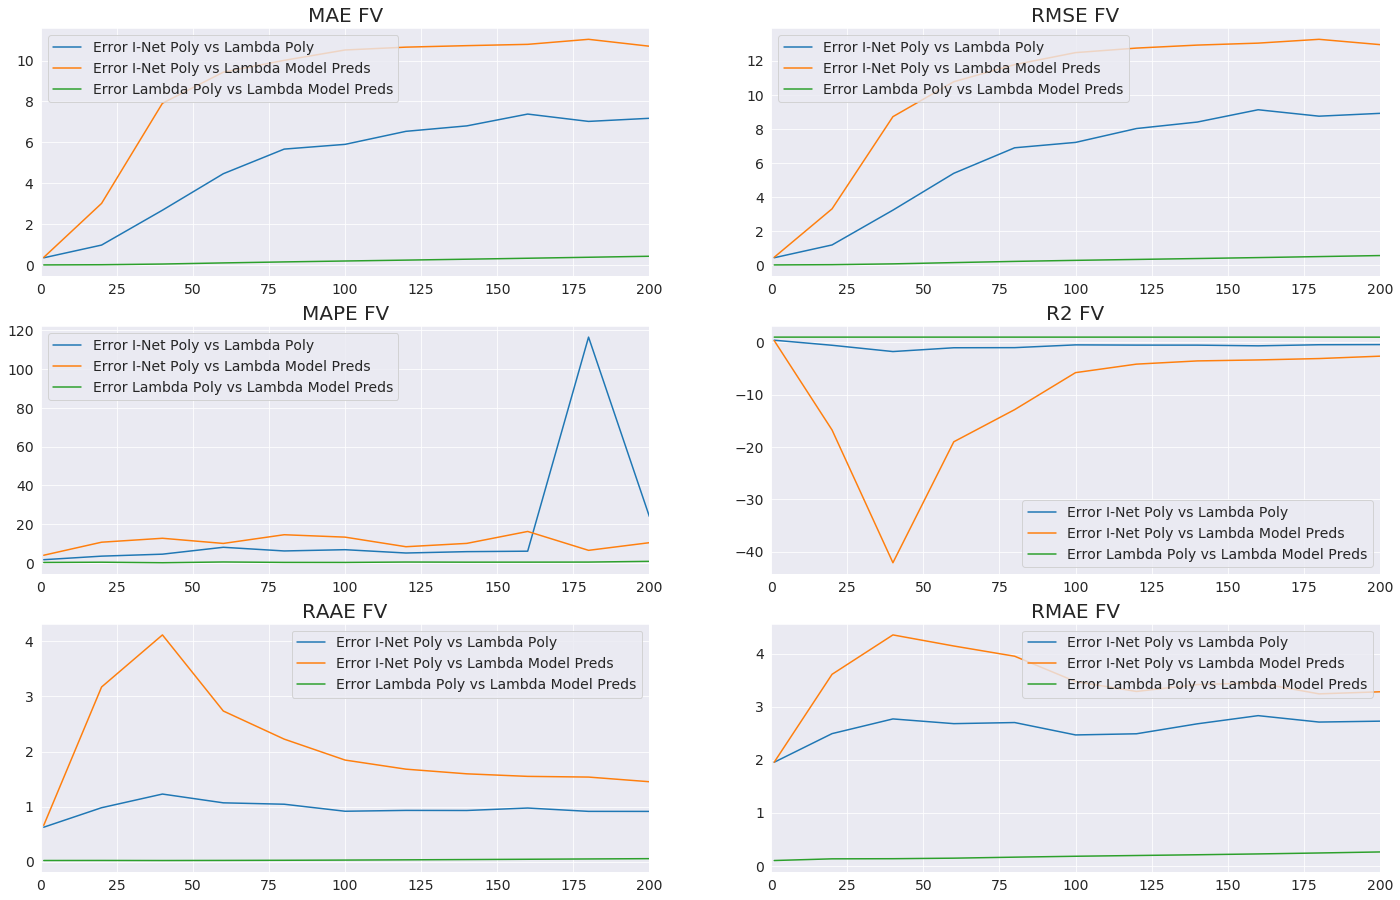

In [45]:
#Generate plot TEST PRED
if multi_epoch_analysis and evaluate_with_real_function:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_cols)
    subplot_number = 1
    plt.figure(figsize=(12*2, 7*length_plt/2))

    #For plotting of the int net, only second value of the tuple can be used for the comparison. Thus, always
    #extract the second value from the scores_int df
    for index in scores_lambda.index:

        vals_int_real = scores_int.loc[index].values
        vals_lambda_real = scores_lambda.loc[index].values[::4]
        vals_lambda_lstsq = scores_lambda.loc[index].values[3::4]

        ax = plt.subplot(length_plt//2+1, 2, subplot_number)
        ax.set_title(index, fontsize=20)
        ax.plot([(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda], vals_int_real, label='Error I-Net Poly vs. Real Poly')
        ax.plot([(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda], vals_lambda_real, label='Error Lambda Model Preds vs. Real Poly')
        ax.plot([(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda], vals_lambda_lstsq, label='Error LSTSQ Preds vs. Real Poly')
        ax.legend(loc="bottom right", fontsize=14)
        ax.set_xlim([0, epochs_lambda])
        
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(14)   
            
        #ax.set_xticks(np.arange(0, epochs, step=1))
        subplot_number += 1
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file = 'multi_epoch_REAL_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file
    
    plt.savefig(path, format='eps')
    plt.show()
    
elif multi_epoch_analysis and not evaluate_with_real_function:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_cols)
    subplot_number = 1
    plt.figure(figsize=(12*2, 7*length_plt/2))

    #For plotting of the int net, only second value of the tuple can be used for the comparison. Thus, always
    #extract the second value from the scores_int df
    for index in scores_lambda.index:

        vals_int_poly = scores_int.loc[index].values[1::2]
        vals_int_preds = scores_int.loc[index].values[::2]
        vals_lambda_poly_pred = scores_lambda.loc[index].values[2::4]

        ax = plt.subplot(length_plt//2+1, 2, subplot_number)
        ax.set_title(index, fontsize=20)
        ax.plot([(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda], vals_int_poly, label='Error I-Net Poly vs Lambda Poly')
        ax.plot([(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda], vals_int_preds, label='Error I-Net Poly vs Lambda Model Preds')
        ax.plot([(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda], vals_lambda_poly_pred, label='Error Lambda Poly vs Lambda Model Preds')
        ax.legend(loc="bottom right", fontsize=14)
        ax.set_xlim([0, epochs_lambda])
        
        
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(14)   
                    
        #ax.set_xticks(np.arange(0, epochs, step=1))
        subplot_number += 1

    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file = 'multi_epoch_MODEL_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file
    
    plt.savefig(path, format='eps')
    plt.show()

elif samples_list != None and evaluate_with_real_function:
    length_plt = len(plot_cols)
    subplot_number = 1
    plt.figure(figsize=(12*2, 7*length_plt/2))

    #For plotting of the int net, only second value of the tuple can be used for the comparison. Thus, always
    #extract the second value from the scores_int df
    for index in scores_int.index:

        vals_int_real = scores_int.loc[index].values
        vals_lambda_real = np.concatenate([scores_lambda.loc[index].values[::4] for i in samples_list], axis=None)
        vals_lambda_lstsq = np.concatenate([scores_lambda.loc[index].values[3::4] for i in samples_list], axis=None)

        ax = plt.subplot(length_plt//2+1, 2, subplot_number)
        ax.set_title(index, fontsize=20)
        ax.plot(samples_list, vals_int_real, label='Error I-Net Poly vs. Real Poly')
        ax.plot(samples_list, vals_lambda_real, label='Error Lambda Model Preds vs. Real Poly')
        ax.plot(samples_list, vals_lambda_lstsq, label='Error LSTSQ Preds vs. Real Poly')
        ax.legend(loc="bottom right", fontsize=14)
        ax.set_xlim([0, samples_list[-1]])

        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(14)   

        #ax.set_xticks(np.arange(0, epochs, step=1))
        subplot_number += 1
    
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file = 'sample_list' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_REAL_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file    
    
    plt.savefig(path, format='eps')
    plt.show()

elif samples_list != None and not evaluate_with_real_function:
    length_plt = len(plot_cols)
    subplot_number = 1
    plt.figure(figsize=(12*2, 7*length_plt/2))

    #For plotting of the int net, only second value of the tuple can be used for the comparison. Thus, always
    #extract the second value from the scores_int df
    for index in scores_int.index:

        vals_int_poly = scores_int.loc[index].values[1::2]
        vals_int_preds = scores_int.loc[index].values[::2]
        vals_lambda_poly_pred = np.concatenate([scores_lambda.loc[index].values[2::4] for i in samples_list], axis=None)
        
        ax = plt.subplot(length_plt//2+1, 2, subplot_number)
        ax.set_title(index, fontsize=20)
        ax.plot(samples_list, vals_int_poly, label='Error I-Net Poly vs Lambda Poly')
        ax.plot(samples_list, vals_int_preds, label='Error I-Net Poly vs Lambda Model Preds')
        ax.plot(samples_list, vals_lambda_poly_pred, label='Error Lambda Poly vs Lambda Model Preds')
        ax.legend(loc="bottom right", fontsize=14)
        ax.set_xlim([0, samples_list[-1]])

        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(14)   

        #ax.set_xticks(np.arange(0, epochs, step=1))
        subplot_number += 1
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file = 'sample_list' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_MODEL_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file    
    
    plt.savefig(path, format='eps')
    plt.show()
        

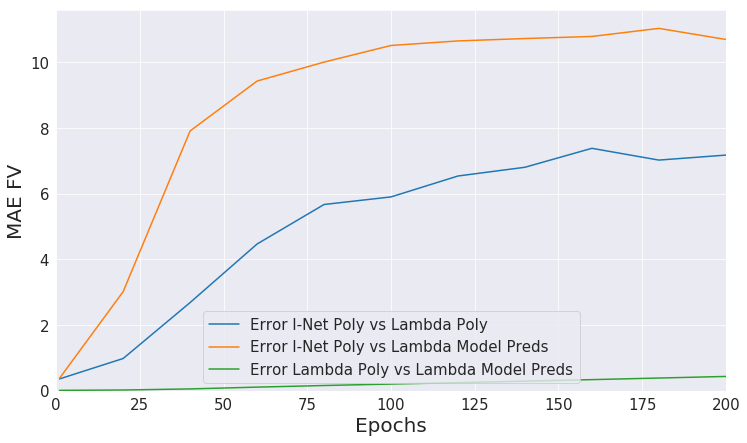

In [46]:
if multi_epoch_analysis and evaluate_with_real_function:
    index = 'MAE FV'

    vals_int_real = scores_int.loc[index].values
    vals_lambda_real = scores_lambda.loc[index].values[::4]
    vals_lambda_lstsq = scores_lambda.loc[index].values[3::4]


    fig, ax = plt.subplots(figsize=(12, 7))
    #ax.set_title('Accuracy Evaluation')

    ax.plot([(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda], vals_int_real, label='Error I-Net Poly vs. Real Poly')
    ax.plot([(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda], vals_lambda_real, label='Error Lambda Model Preds vs. Real Poly')
    ax.plot([(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda], vals_lambda_lstsq, label='Error LSTSQ Preds vs. Real Poly')

    ax.set_ylabel(index, fontsize=20)
    ax.set_xlabel('Epochs', fontsize=20)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(15)

    ax.legend(loc="bottom right", fontsize=15)
    ax.set_xlim([0, epochs_lambda])
    ax.set_ylim(bottom=0)
    #ax.set_xticks(np.arange(0, epochs, step=1))
    
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file = 'multi_epoch_REAL_' + index + '_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file 
    
    fig.savefig(path, format='eps')
    
elif multi_epoch_analysis and not evaluate_with_real_function:
       
    index = 'MAE FV'

    vals_int_poly = scores_int.loc[index].values[1::2]
    vals_int_preds = scores_int.loc[index].values[::2]
    vals_lambda_poly_pred = scores_lambda.loc[index].values[2::4]


    fig, ax = plt.subplots(figsize=(12, 7))
    #ax.set_title('Accuracy Evaluation')

    ax.plot([(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda], vals_int_poly, label='Error I-Net Poly vs Lambda Poly')
    ax.plot([(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda], vals_int_preds, label='Error I-Net Poly vs Lambda Model Preds')
    ax.plot([(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda], vals_lambda_poly_pred, label='Error Lambda Poly vs Lambda Model Preds')

    ax.set_ylabel(index, fontsize=20)
    ax.set_xlabel('Epochs', fontsize=20)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(15)

    ax.legend(loc="bottom right", fontsize=15)
    ax.set_xlim([0, epochs_lambda])
    ax.set_ylim(bottom=0)
    
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file = 'multi_epoch_MODEL_' + index + '_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file
        
    fig.savefig(path, format='eps')

elif samples_list != None and evaluate_with_real_function:
    index = 'MAE FV'

    vals_int_real = scores_int.loc[index].values
    vals_lambda_real = np.concatenate([scores_lambda.loc[index].values[::4] for i in samples_list], axis=None)
    vals_lambda_lstsq = np.concatenate([scores_lambda.loc[index].values[3::4] for i in samples_list], axis=None)
        
    fig, ax = plt.subplots(figsize=(12, 7))
    
    ax.plot(samples_list, vals_int_real, label='Error I-Net Poly vs. Real Poly')
    ax.plot(samples_list, vals_lambda_real, label='Error Lambda Model Preds vs. Real Poly')
    ax.plot(samples_list, vals_lambda_lstsq, label='Error LSTSQ Preds vs. Real Poly')
        
    ax.set_ylabel(index, fontsize=20)
    ax.set_xlabel('Training Set Size I-Net', fontsize=20)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(15)   
    
    ax.legend(loc="bottom right", fontsize=15)
    ax.set_xlim([0, samples_list[-1]])
    ax.set_ylim(bottom=0)
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file = 'sample_list_' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_REAL_' + index + '_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file
    
    fig.savefig(path, format='eps')

elif samples_list != None and not evaluate_with_real_function:
    index = 'MAE FV'


    vals_int_poly = scores_int.loc[index].values[1::2]
    vals_int_preds = scores_int.loc[index].values[::2]
    vals_lambda_poly_pred = np.concatenate([scores_lambda.loc[index].values[2::4] for i in samples_list], axis=None)

        
    fig, ax = plt.subplots(figsize=(12, 7))

    ax.plot(samples_list, vals_int_poly, label='Error I-Net Poly vs Lambda Poly')
    ax.plot(samples_list, vals_int_preds, label='Error I-Net Poly vs Lambda Model Preds')
    ax.plot(samples_list, vals_lambda_poly_pred, label='Error Lambda Poly vs Lambda Model Preds')
    
    ax.set_ylabel(index, fontsize=20)
    ax.set_xlabel('Training Set Size I-Net', fontsize=20)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(15)   
    
    ax.legend(loc="bottom right", fontsize=15)
    ax.set_xlim([0, samples_list[-1]])
    ax.set_ylim(bottom=0)
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file = 'sample_list_' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_MODEL_' + index + '_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file
        
    fig.savefig(path, format='eps')


#### Generate and Analyze Predictions for Random Function

In [47]:
if multi_epoch_analysis:
    plot_preds = polynomial_test_fv_list[-1]
    plot_eval = lambda_test_fv_test_split_list[-1].iloc[:,1:]
elif samples_list != None:
    plot_preds = polynomial_test_fv_list[-1]
    plot_eval = lambda_test_fv_test_split.iloc[:,1:]
else:
    plot_preds = polynomial_test_fv
    plot_eval = lambda_test_fv_test_split.iloc[:,1:]

x_vars = ['x' + str(i) for i in range(1, n+1)]

columns = x_vars.copy()
columns.append('FVs')

columns_single = x_vars.copy()
columns_single.extend(['Real Poly FVs (Target)', 'Int Pred Poly FVs', 'Lambda Preds'])

eval_size_plot = plot_preds[2].shape[1]
rand_index = 42#random.randint(0, plot_preds[2].shape[0]-1)
vars_plot = np.column_stack([lambda_test_input_test_split[rand_index][::,i] for i in range(n)])
plot_data_single = pd.DataFrame(data=np.column_stack([vars_plot, plot_preds[2][rand_index], plot_preds[3][rand_index], plot_eval.values[rand_index]]), columns=columns_single)

vars_plot_all_preds = np.append(np.append(vars_plot, vars_plot, axis=0), vars_plot, axis=0)
preds_plot_all = np.append(np.append(plot_preds[2][rand_index], plot_preds[3][rand_index], axis=0), plot_eval.values[rand_index], axis=0)

if evaluate_with_real_function:
    real_str = np.array(['Real Poly FVs (Target)' for i in range(eval_size_plot)])
    int_str = np.array(['Int Pred Poly FVs' for i in range(eval_size_plot)])
    lambda_str = np.array(['Lambda Preds' for i in range(eval_size_plot)])
    #Add Lambda Poly Preds LSTSQ
else:
    real_str = np.array(['Lambda Poly FVs (Target)' for i in range(eval_size_plot)])
    int_str = np.array(['Int Pred Poly FVs' for i in range(eval_size_plot)])
    lambda_str = np.array(['Lambda Preds' for i in range(eval_size_plot)])
    #Add Lambda Poly Preds
    
identifier = np.concatenate([real_str, int_str, lambda_str])

plot_data = pd.DataFrame(data=np.column_stack([vars_plot_all_preds, preds_plot_all]), columns=columns)
plot_data['Identifier'] = identifier



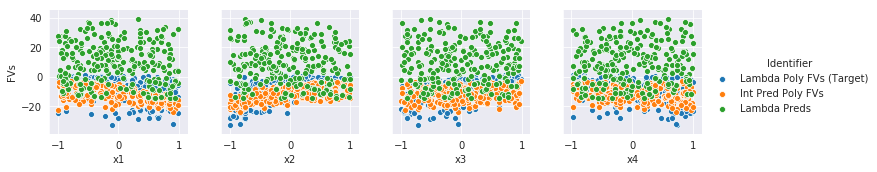

In [48]:
pp1 = sns.pairplot(data=plot_data,
                  #kind='reg',
                  hue='Identifier',
                  y_vars=['FVs'],
                  x_vars=x_vars)

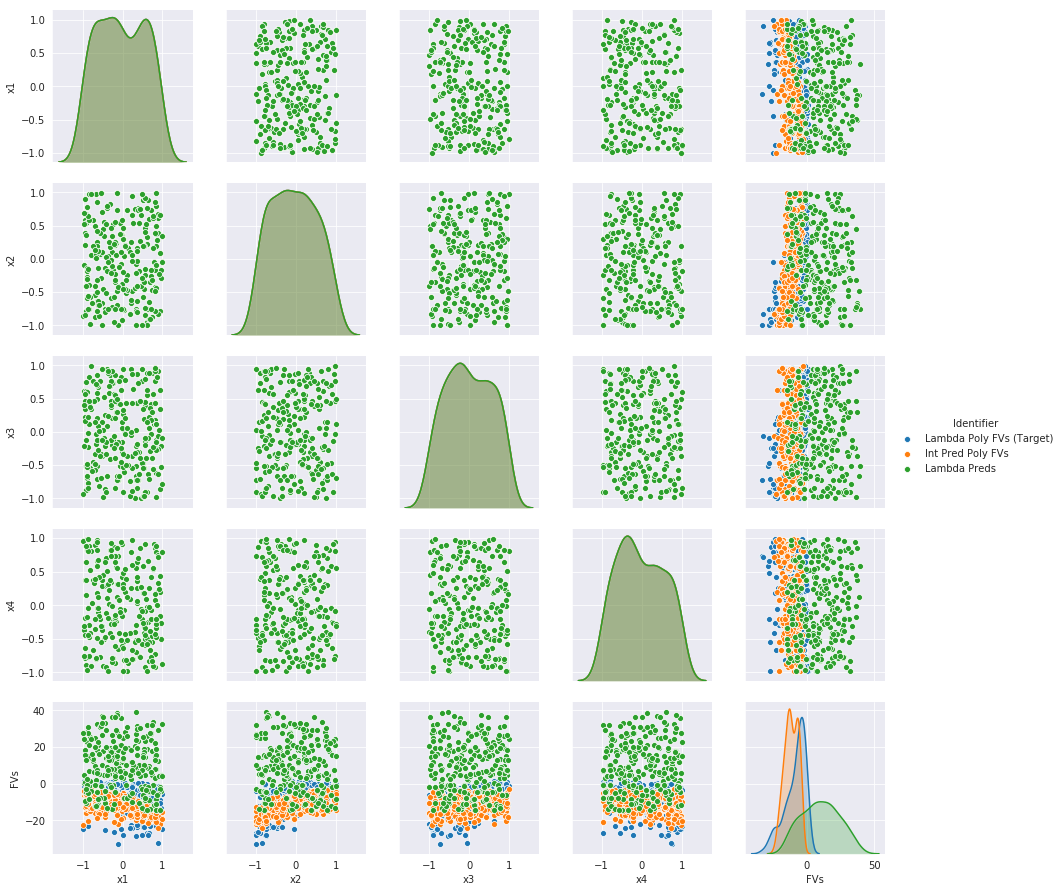

In [49]:
pp2 = sns.pairplot(data=plot_data,
                  #kind='reg',
                  hue='Identifier',
                  #y_vars=['FVs'],
                  #x_vars=x_vars
                 )

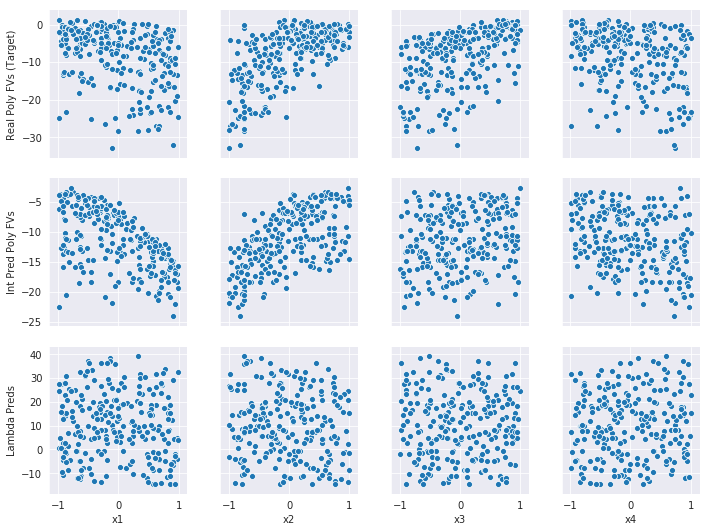

In [50]:
pp3 = sns.pairplot(data=plot_data_single,
                  #kind='reg',
                  y_vars=['Real Poly FVs (Target)', 'Int Pred Poly FVs', 'Lambda Preds'],
                  x_vars=x_vars)

In [51]:
if evaluate_with_real_function:
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file1 = 'pp3in1_REAL_' + str(rand_index) + '_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    file2 = 'pp3in1_extended_REAL_' + str(rand_index) + '_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    file3 = 'pp1_REAL_' + str(rand_index) + '_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    
    path1 = location + folder + file1
    path2 = location + folder + file2
    path3 = location + folder + file3
    
    pp1.savefig(path1, format='eps')
    pp2.savefig(path2, format='eps')
    pp3.savefig(path3, format='eps')
else:
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file1 = 'pp3in1_PRED_' + str(rand_index) + '_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    file2 = 'pp3in1_extended_PRED_' + str(rand_index) + '_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    file3 = 'pp1_PRED_' + str(rand_index) + '_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    
    path1 = location + folder + file1
    path2 = location + folder + file2
    path3 = location + folder + file3
    
    pp1.savefig(path1, format='eps')
    pp2.savefig(path2, format='eps')
    pp3.savefig(path3, format='eps')    
    

### Single Network Analysis

In [52]:
if not multi_epoch_analysis and samples_list == None: 
    #%%script false --no-raise-error
    path_loss = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/history_loss_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
    path_metric = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n)+ '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/history_metric_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
    path_val_loss = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/history_val_loss_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
    path_val_metric = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/history_val_metric_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'


    loss_df_lambda = pd.read_csv(path_loss, sep=',')
    metric_df_lambda = pd.read_csv(path_metric, sep=',')
    val_loss_df_lambda = pd.read_csv(path_val_loss, sep=',')
    val_metric_df_lambda = pd.read_csv(path_val_metric, sep=',')


In [53]:
if not multi_epoch_analysis and samples_list == None: 

    #%%script false --no-raise-error
    adjustment_threshold_metric = 0

    metric_df_adjusted = metric_df_lambda.copy(deep=True)
    metric_df_adjusted[metric_df_adjusted.columns] = np.where(metric_df_adjusted[metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, metric_df_adjusted[metric_df_adjusted.columns])

    val_metric_df_adjusted = val_metric_df_lambda.copy(deep=True)
    val_metric_df_adjusted[val_metric_df_adjusted.columns] = np.where(val_metric_df_adjusted[val_metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, val_metric_df_adjusted[val_metric_df_adjusted.columns])


    plt.plot(metric_df_adjusted.describe().loc['mean'].values)
    plt.plot(val_metric_df_adjusted.describe().loc['mean'].values)
    #plt.plot(random_network[2].history['val_metric'])
    plt.title('model metric')
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [54]:
if not multi_epoch_analysis and samples_list == None: 
    #%%script false --no-raise-error
    adjustment_threshold_loss = 1000

    loss_df_adjusted = loss_df_lambda.copy(deep=True)
    loss_df_adjusted[loss_df_adjusted.columns] = np.where(loss_df_adjusted[loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, loss_df_adjusted[loss_df_adjusted.columns])

    val_loss_df_adjusted = val_loss_df_lambda.copy(deep=True)
    val_loss_df_adjusted[val_loss_df_adjusted.columns] = np.where(val_loss_df_adjusted[val_loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, val_loss_df_adjusted[val_loss_df_adjusted.columns])


    plt.plot(loss_df_adjusted.describe().loc['mean'].values)
    plt.plot(val_loss_df_adjusted.describe().loc['mean'].values)
    #plt.plot(random_network[2].history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()


In [55]:
if not multi_epoch_analysis and samples_list == None: 
    preds = model.predict(X_test[:,2:])
    preds_rounded = np.round(preds, 1)
    #preds_true = pd.DataFrame(data=[np.round(preds, 1), y_test.values])
    for pred, y in tqdm(zip(preds_rounded, y_test.values)):
        if (pred == y).all():
            print(pred)
    
    #print(preds_rounded)
    #print(y_test.values)

In [56]:
#summarize history for loss
if not multi_epoch_analysis and samples_list == None: 
    plt.plot(history['loss'])
    try:
        plt.plot(history['val_loss'])
    except KeyError:
        print('no val_loss in keys')
    #plt.plot(random_network[2].history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/loss_' + interpretation_network_string + filename + '.png')
    plt.show()
    

# BENCHMARK (RANDOM GUESS) EVALUATION

In [57]:
list_of_random_polynomials = []
for i in range(y_test.shape[0]):
    random_polynomial = list(random_product([i*a_step for i in range(int(a_min*10**int(-np.log10(a_step))), int(a_max*10**int(-np.log10(a_step))))], repeat=nCr(n+d, d)))
    list_of_random_polynomials.append(random_polynomial)

In [58]:
true_fv_test = parallel_fv_calculation_from_polynomial(y_test.values[:,2:], lambda_test_input_test_split)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_test_input_test_split)

In [59]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(y_test.values[:,2:], list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 5.4534


In [60]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 13.3574


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [61]:
true_fv_train = parallel_fv_calculation_from_polynomial(y_train.values[:,2:], lambda_train_input_train_split)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [62]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 8.504
